In [2]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import networkx as nx
import tensorflow as tf
import umap

from tensorflow import keras
from tqdm import tqdm
from pathlib import Path

from astropy import units as u
from astropy.coordinates import SkyCoord
from tensorflow.keras.utils import pad_sequences

from astroOracle.dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length, get_ts_upto_days_since_trigger, ts_flag_value, static_flag_value, augment_ts_length_to_days_since_trigger
from astroOracle.loss import WHXE_Loss
from astroOracle.taxonomy import get_taxonomy_tree, source_node_label
from astroOracle.vizualizations import make_gif, plot_reliability_diagram, plot_data_set_composition, plot_day_vs_class_score, plot_lc, make_z_plots
from astroOracle.interpret_results import get_conditional_probabilites, save_all_cf_and_rocs, save_leaf_cf_and_rocs, save_all_phase_vs_accuracy_plot
from astroOracle.train_RNN import default_batch_size
from astroOracle.LSST_Source import LSST_Source

In [4]:
# This step takes a while because it has load from disc to memory...
print("Loading testing data from disc...")
test_dir = Path("../processed/test")
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

Loading testing data from disc...


In [5]:
max_class_count = 10
for i in tqdm(range(len(X_static))):        
    X_static[i] = get_static_features(X_static[i])

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
astrophysical_classes_balanced = []

# Fix random seed while generating LCs for figure 19
random.seed(42)

for c in np.unique(astrophysical_classes):

    idx = list(np.where(np.array(astrophysical_classes) == c)[0])
    
    if len(idx) > max_class_count:
        idx = random.sample(idx, max_class_count)

    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463528/463528 [00:01<00:00, 241056.62it/s]


In [6]:
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 20
color_arr=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [8]:
model = keras.models.load_model(f"../models/lsst_alpha_0.5/best_model.h5", compile=False)
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

In [9]:
all_embeddings = []
all_trues = []
days = 2 ** np.array(range(11))

for d in days:

    print(f'Running inference for trigger + {d} days...')

    x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, d)
    
    # Run inference on these
    latent_space_embeddings = hidden_layer_model.predict([x1, x2], batch_size=default_batch_size)

    all_embeddings.append(latent_space_embeddings)
    all_trues.append(y_true)
    
    print(f'For trigger + {d} days, these are the statistics:')


Running inference for trigger + 1 days...
1/1 [==============================] - 1s 972ms/step
For trigger + 1 days, these are the statistics:
Running inference for trigger + 2 days...
1/1 [==============================] - 0s 386ms/step
For trigger + 2 days, these are the statistics:
Running inference for trigger + 4 days...
1/1 [==============================] - 0s 391ms/step
For trigger + 4 days, these are the statistics:
Running inference for trigger + 8 days...
1/1 [==============================] - 0s 411ms/step
For trigger + 8 days, these are the statistics:
Running inference for trigger + 16 days...
1/1 [==============================] - 0s 428ms/step
For trigger + 16 days, these are the statistics:
Running inference for trigger + 32 days...
1/1 [==============================] - 0s 463ms/step
For trigger + 32 days, these are the statistics:
Running inference for trigger + 64 days...
1/1 [==============================] - 0s 489ms/step
For trigger + 64 days, these are the stati

In [10]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(np.concatenate(all_embeddings))
embedding.shape

/Users/vedshah/anaconda3/envs/temp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2090, 2)

1 Days after trigger


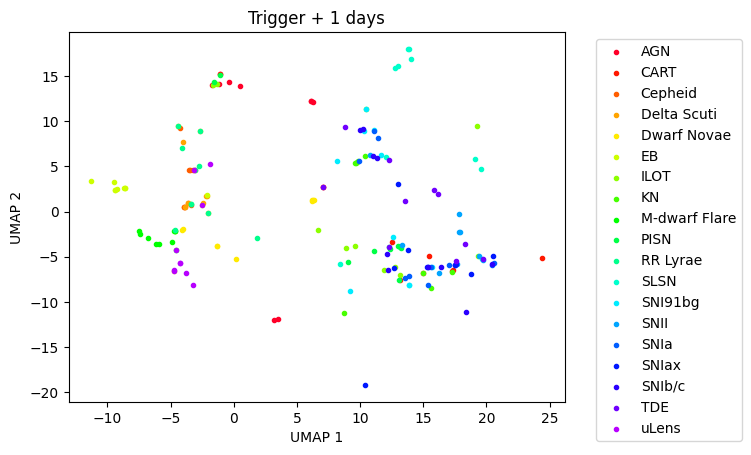

2 Days after trigger


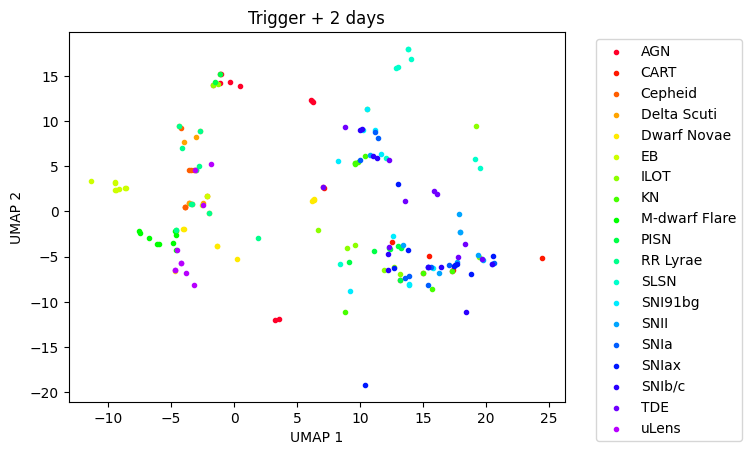

4 Days after trigger


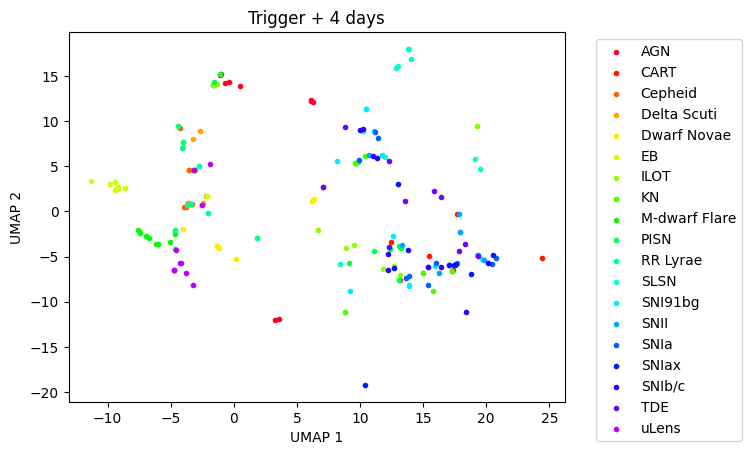

8 Days after trigger


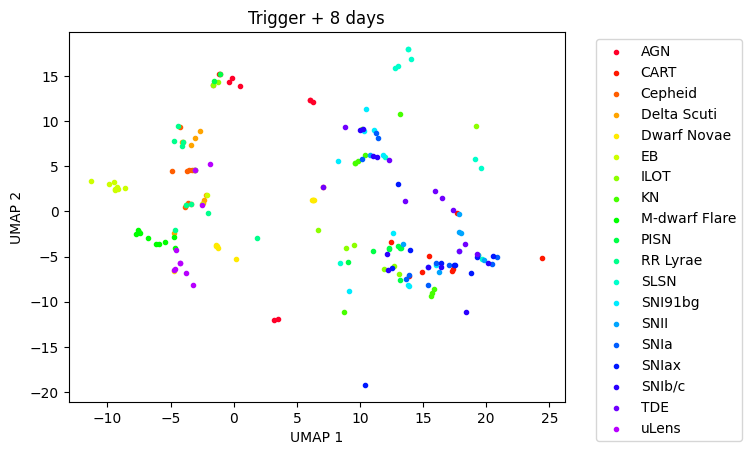

16 Days after trigger


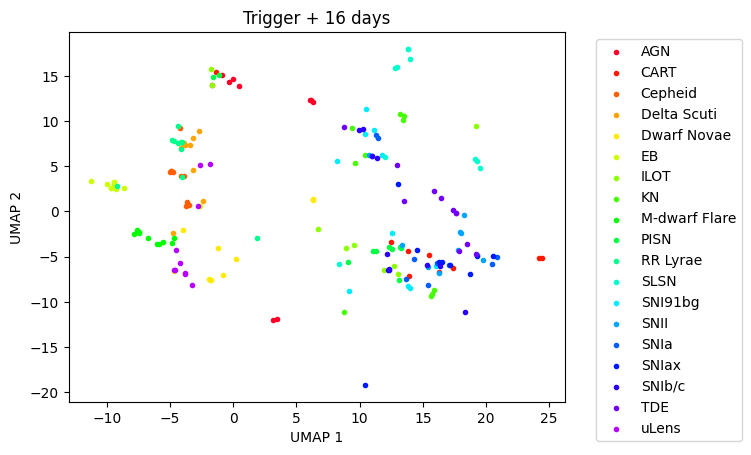

32 Days after trigger


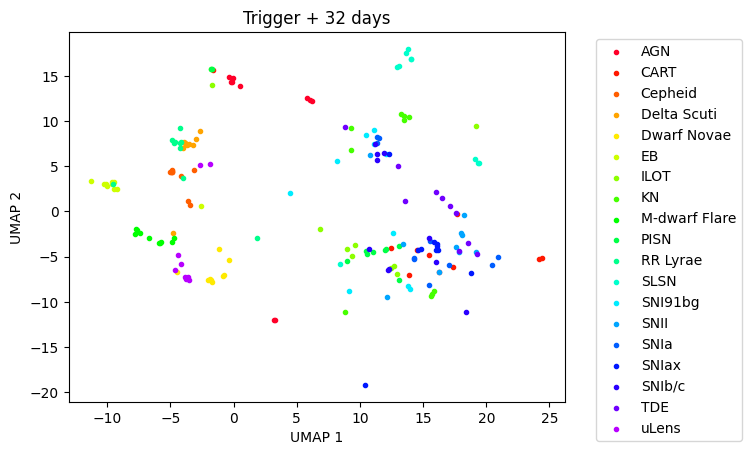

64 Days after trigger


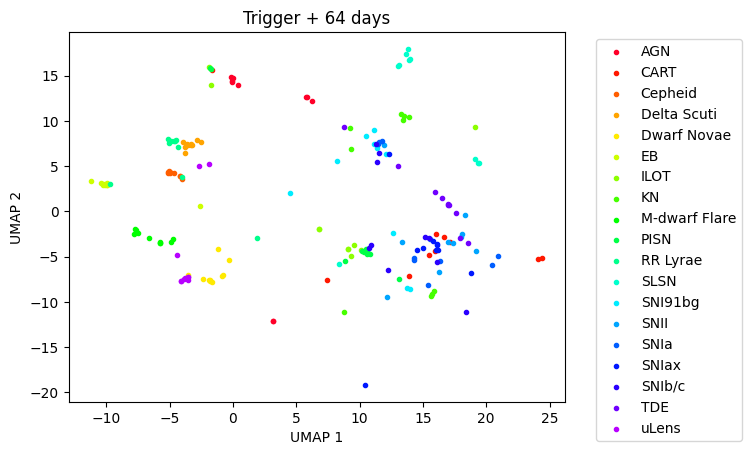

128 Days after trigger


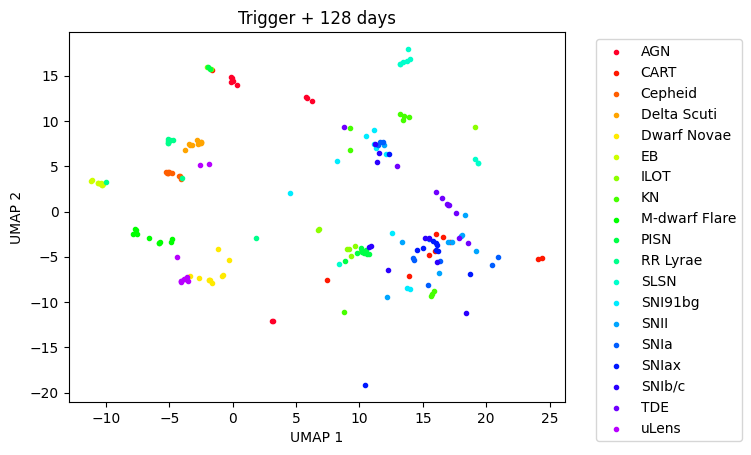

256 Days after trigger


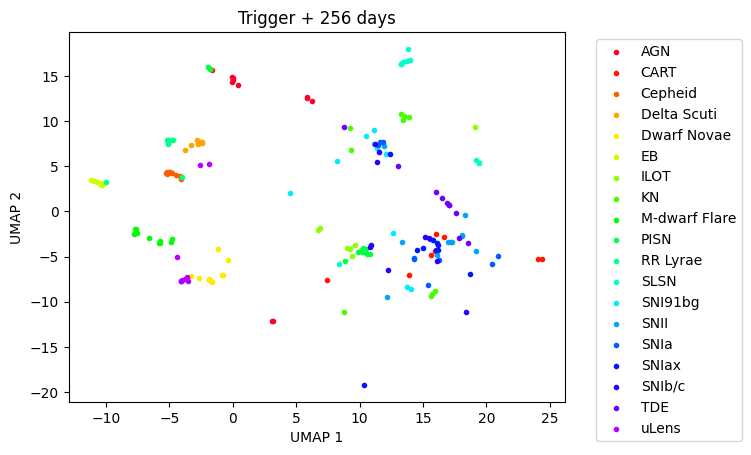

512 Days after trigger


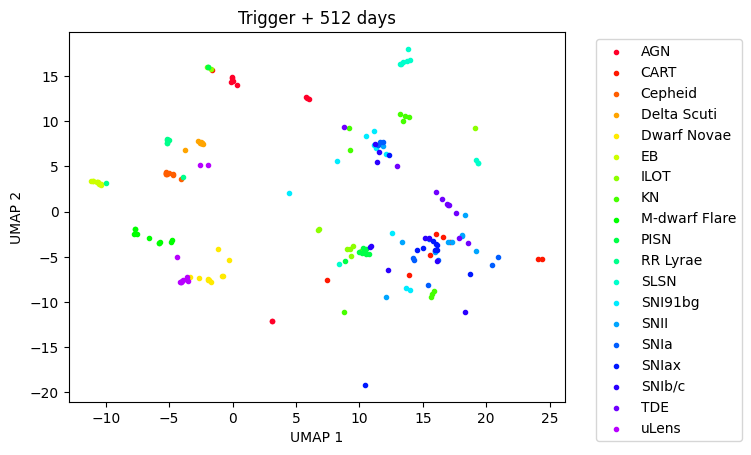

1024 Days after trigger


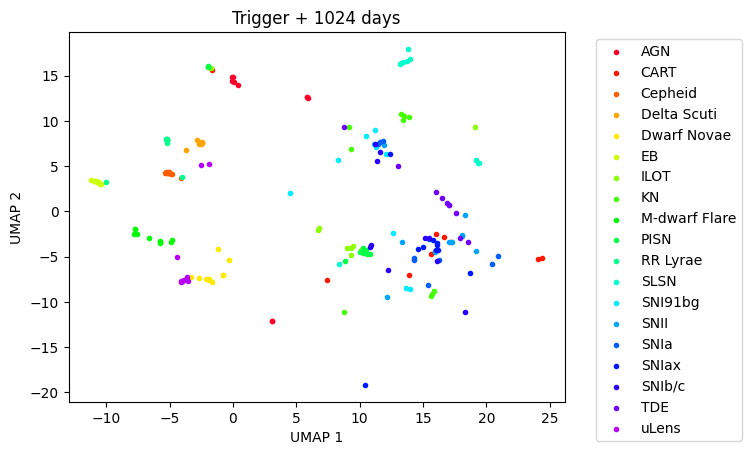

FileNotFoundError: No such file: '/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/notebooks/Embedding_plots/leaf_1.png'

In [12]:
for i,d in enumerate(days):
    print(f"{d} Days after trigger")
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]
    for j, c in enumerate(np.unique(astrophysical_classes_balanced)):
        
        idx = np.where(np.array(astrophysical_classes_balanced)==c)

        plt.scatter(data_for_d[idx, 0], data_for_d[idx, 1], label=c, marker='.', color=color_arr[j])

        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Trigger + {d} days")
    plt.savefig(f"../Embedding_plots/leaf_{d}.png",bbox_inches='tight')
    plt.show()
    
leaf_embeddings = [f"Embedding_plots/leaf_{d}.png" for d in days]
make_gif(leaf_embeddings, "../Embedding_plots/leaf.gif")
plt.close()

In [13]:
mapping_level_1 = {
'AGN': 'AGN',
'CART': 'Long',
'Cepheid': 'Periodic',
'Delta Scuti': 'Periodic',
'Dwarf Novae': 'Short',
'EB': 'Periodic',
'ILOT': 'Long',
'KN': 'Short',
'M-dwarf Flare': 'Short',
'PISN': 'Long',
'RR Lyrae': 'Periodic',
'SLSN': 'Long',
'SNI91bg': 'SN',
'SNII': 'SN',
'SNIa': 'SN',
'SNIax': 'SN',
'SNIb/c': 'SN',
'TDE': 'Long',
'uLens': 'Short',
}

In [14]:
mapping_level_2 = {
"SN":"Transient",
"Long":"Transient",
"Short":"Transient",
"Periodic":"Variable",
"AGN":"Variable",
}

In [15]:
l2_labels = [mapping_level_1[a] for a in astrophysical_classes_balanced]
np.unique(l2_labels)

array(['AGN', 'Long', 'Periodic', 'SN', 'Short'], dtype='<U8')

In [16]:
l1_labels = [mapping_level_2[a] for a in l2_labels]
np.unique(l1_labels)

array(['Transient', 'Variable'], dtype='<U9')

1 Days after trigger


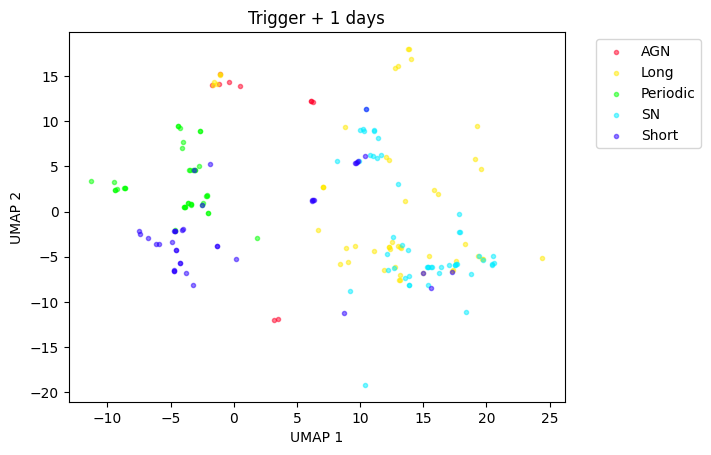

2 Days after trigger


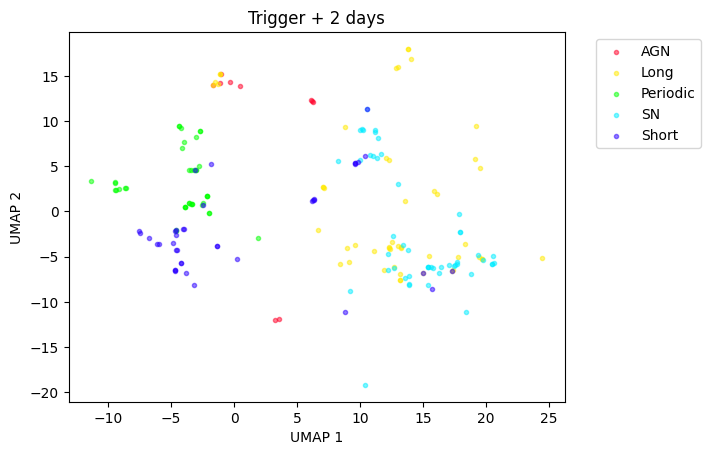

4 Days after trigger


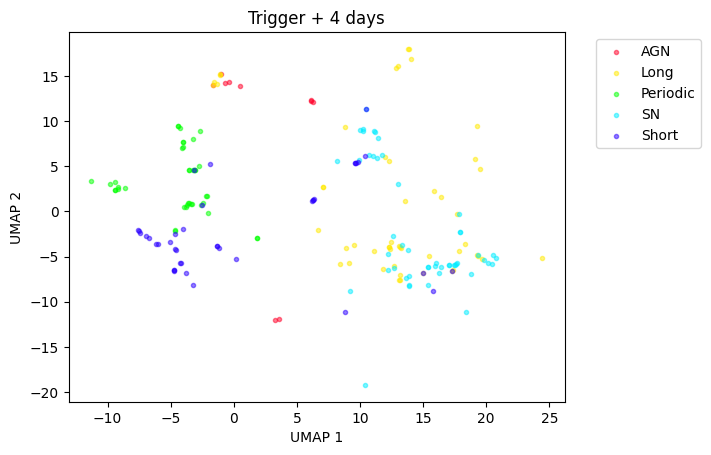

8 Days after trigger


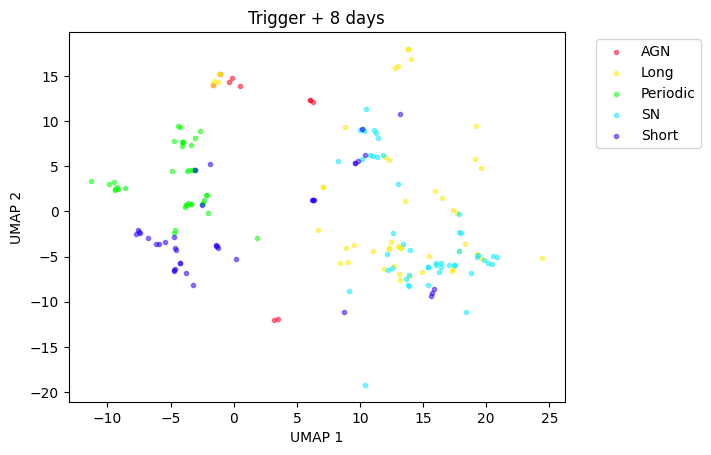

16 Days after trigger


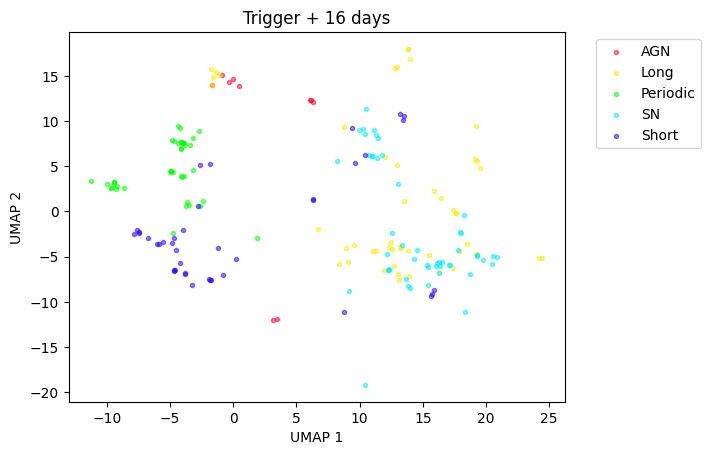

32 Days after trigger


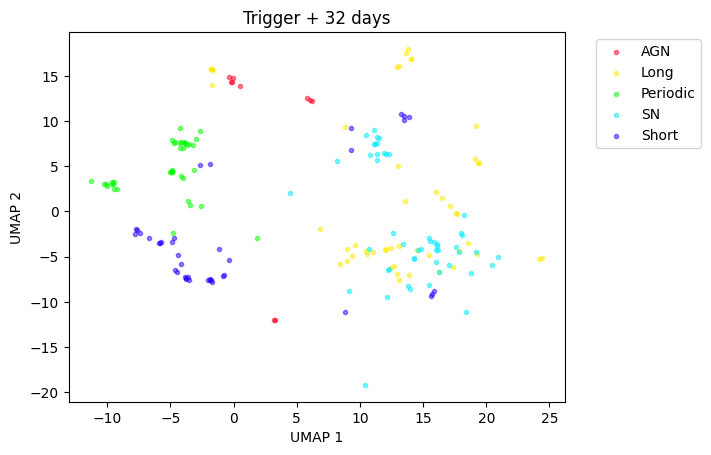

64 Days after trigger


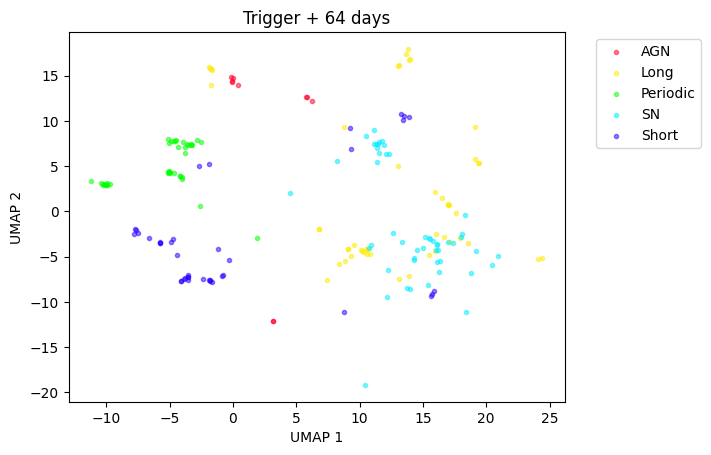

128 Days after trigger


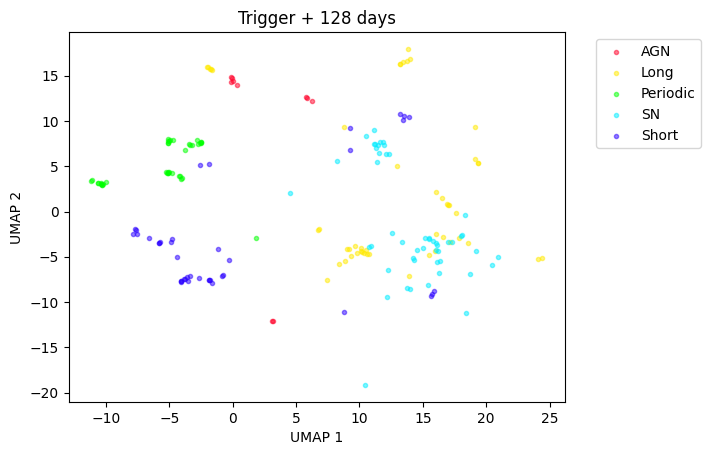

256 Days after trigger


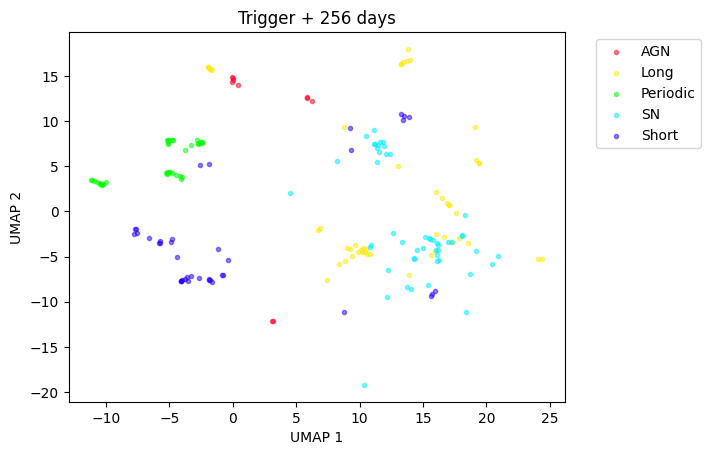

512 Days after trigger


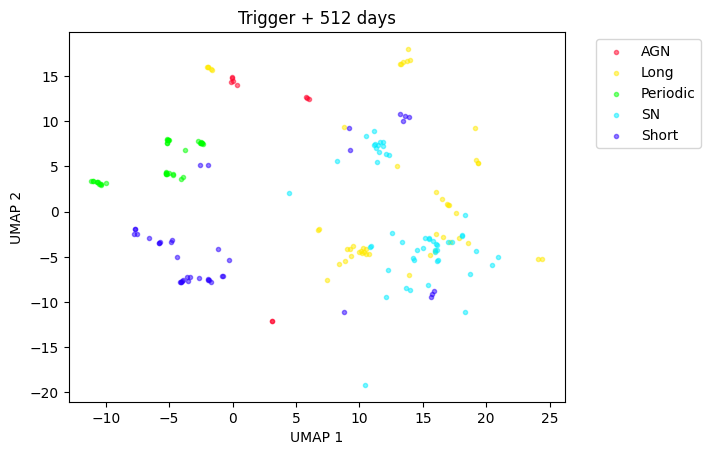

1024 Days after trigger


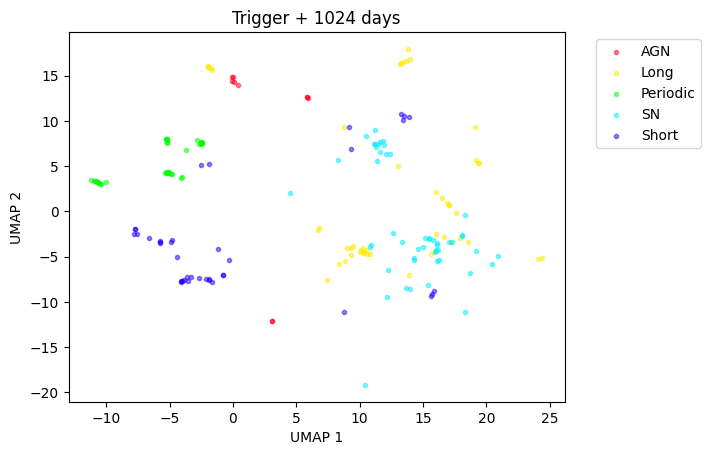

MovieWriter stderr:
dyld[28328]: Library not loaded: /opt/local/lib/libxcb.1.dylib
  Referenced from: <67E793D6-BC9B-38D4-8609-5815A4E33270> /Applications/mesasdk/bin/ffmpeg
  Reason: tried: '/opt/local/lib/libxcb.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libxcb.1.dylib' (no such file), '/opt/local/lib/libxcb.1.dylib' (no such file), '/usr/lib/libxcb.1.dylib' (no such file, not in dyld cache)



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x1800', '-pix_fmt', 'rgba', '-framerate', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', '../Embedding_plots/level2.gif']' died with <Signals.SIGABRT: 6>.

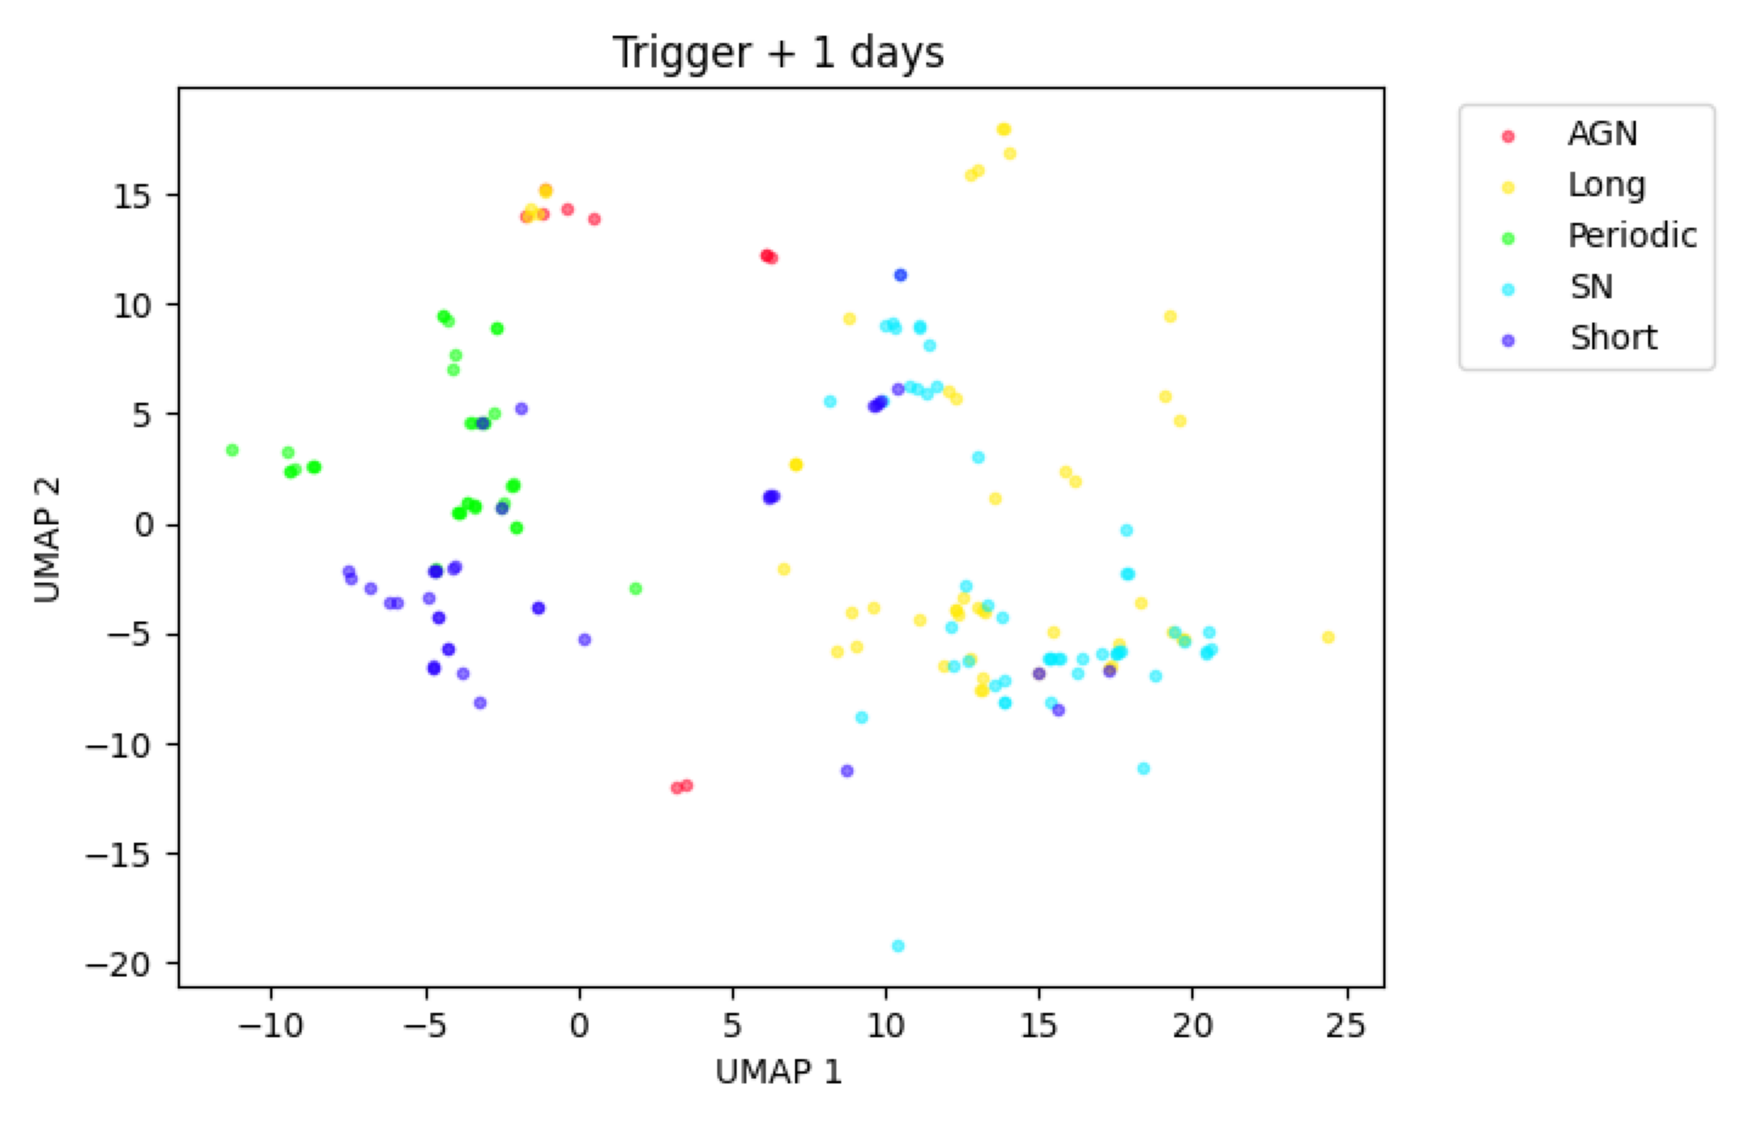

In [17]:
for i,d in enumerate(days):
    
    print(f"{d} Days after trigger")
    
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]
    for j, c in enumerate(np.unique(l2_labels)):
        
        idx = np.where(np.array(l2_labels)==c)

        plt.scatter(data_for_d[idx, 0], data_for_d[idx, 1], label=c, marker='.', color=color_arr[j*4], alpha=0.5)
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Trigger + {d} days")
    plt.savefig(f"../Embedding_plots/level2_{d}.png",bbox_inches='tight')
    plt.show()
    
level2_embeddings = [f"../Embedding_plots/level2_{d}.png" for d in days]
make_gif(level2_embeddings, "../Embedding_plots/level2.gif")
plt.close()

1 Days after trigger


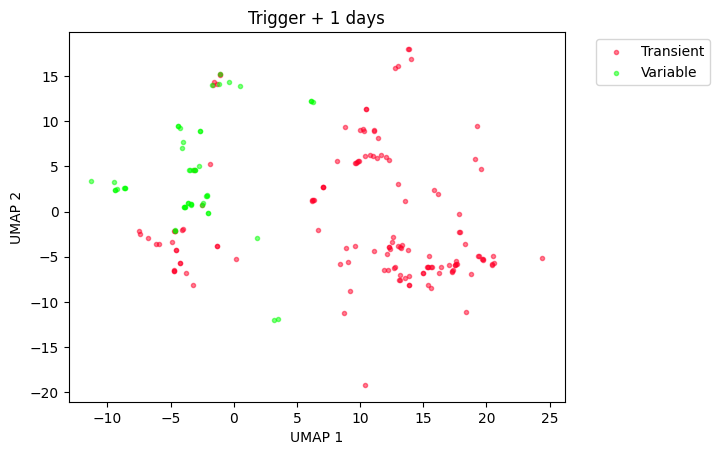

2 Days after trigger


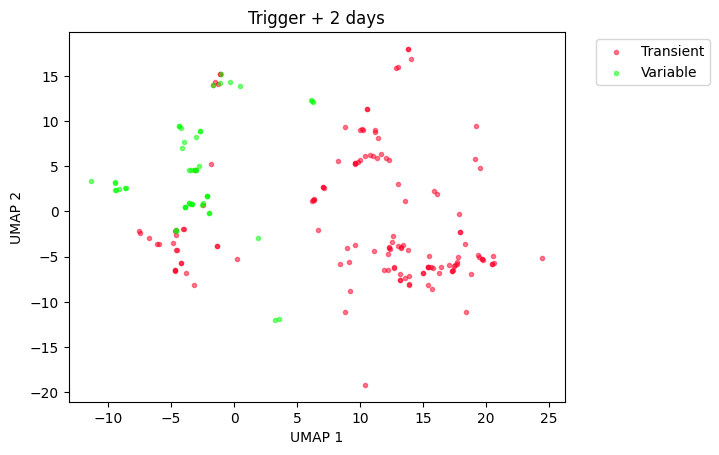

4 Days after trigger


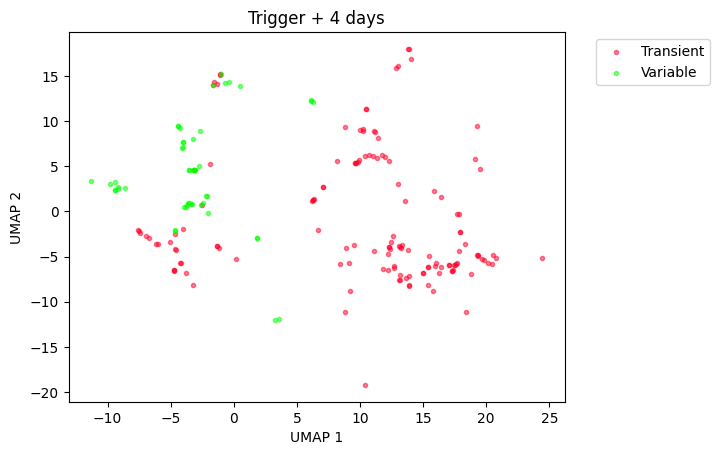

8 Days after trigger


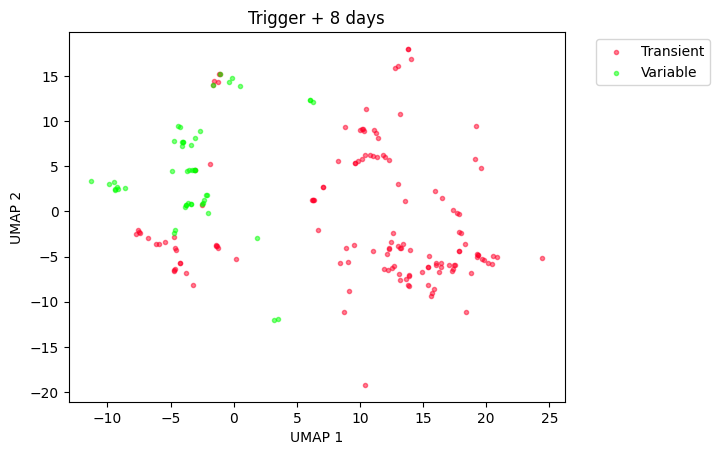

16 Days after trigger


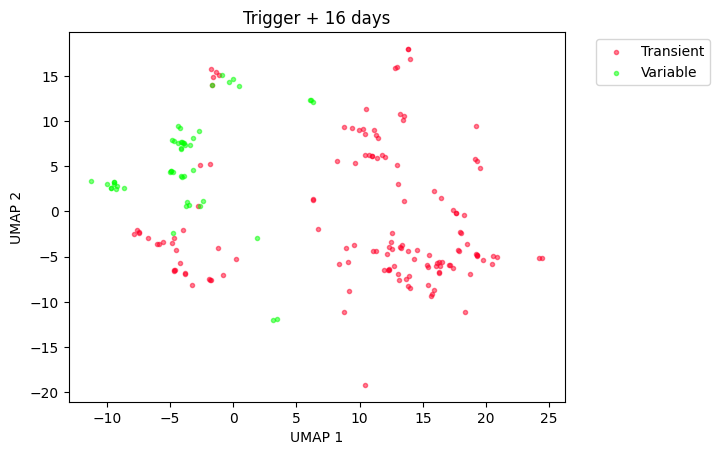

32 Days after trigger


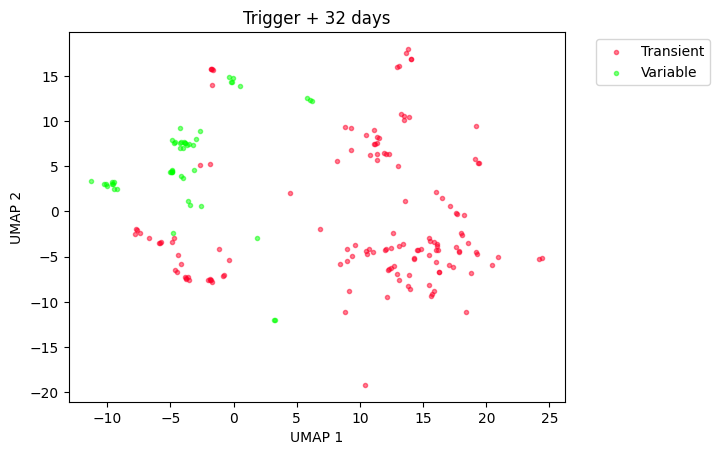

64 Days after trigger


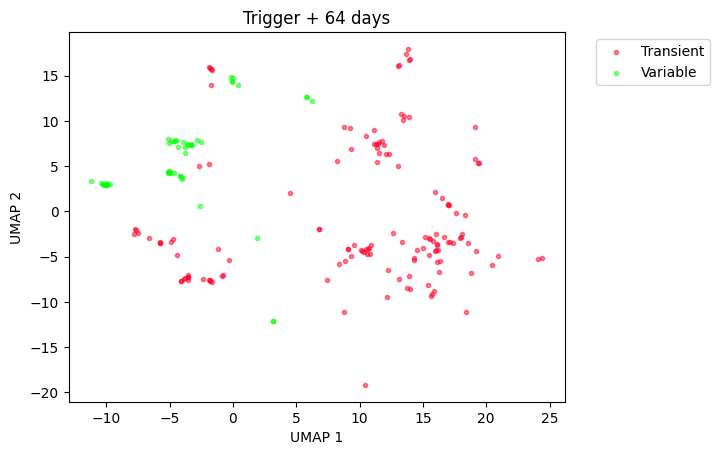

128 Days after trigger


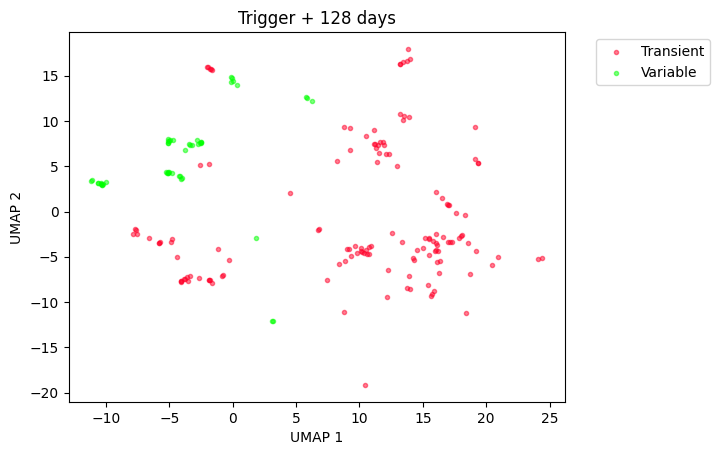

256 Days after trigger


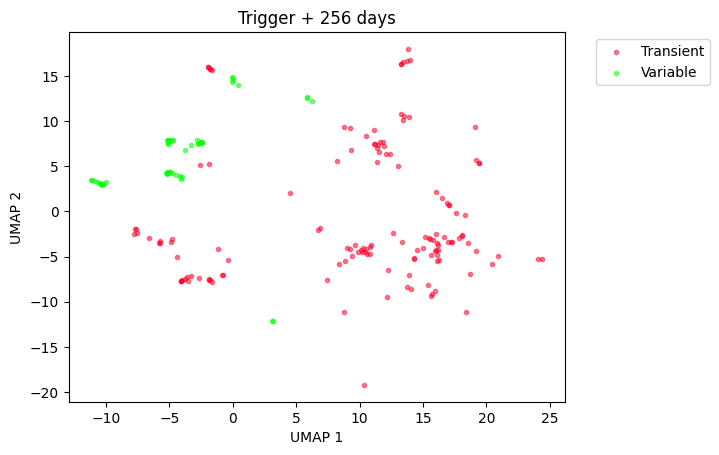

512 Days after trigger


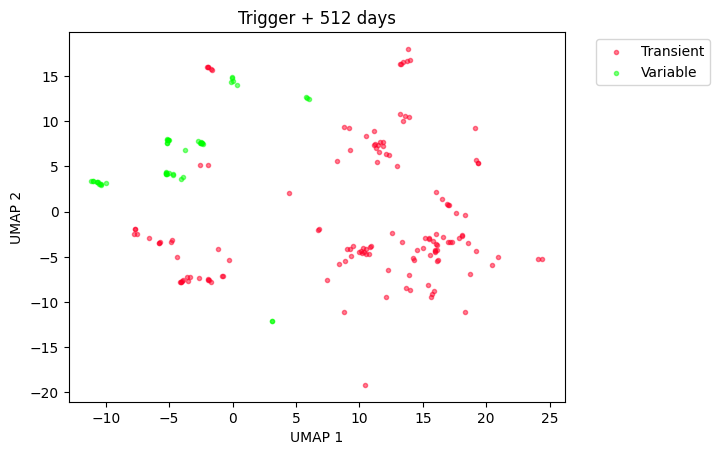

1024 Days after trigger


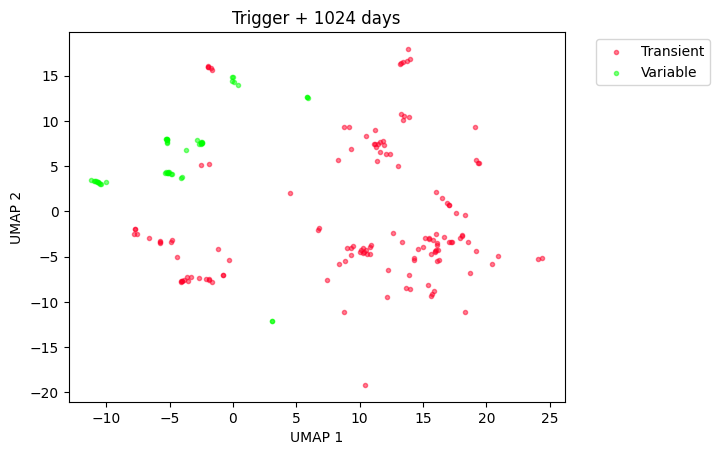

MovieWriter stderr:
dyld[28363]: Library not loaded: /opt/local/lib/libxcb.1.dylib
  Referenced from: <67E793D6-BC9B-38D4-8609-5815A4E33270> /Applications/mesasdk/bin/ffmpeg
  Reason: tried: '/opt/local/lib/libxcb.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libxcb.1.dylib' (no such file), '/opt/local/lib/libxcb.1.dylib' (no such file), '/usr/lib/libxcb.1.dylib' (no such file, not in dyld cache)



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x1800', '-pix_fmt', 'rgba', '-framerate', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', '../Embedding_plots/level1.gif']' died with <Signals.SIGABRT: 6>.

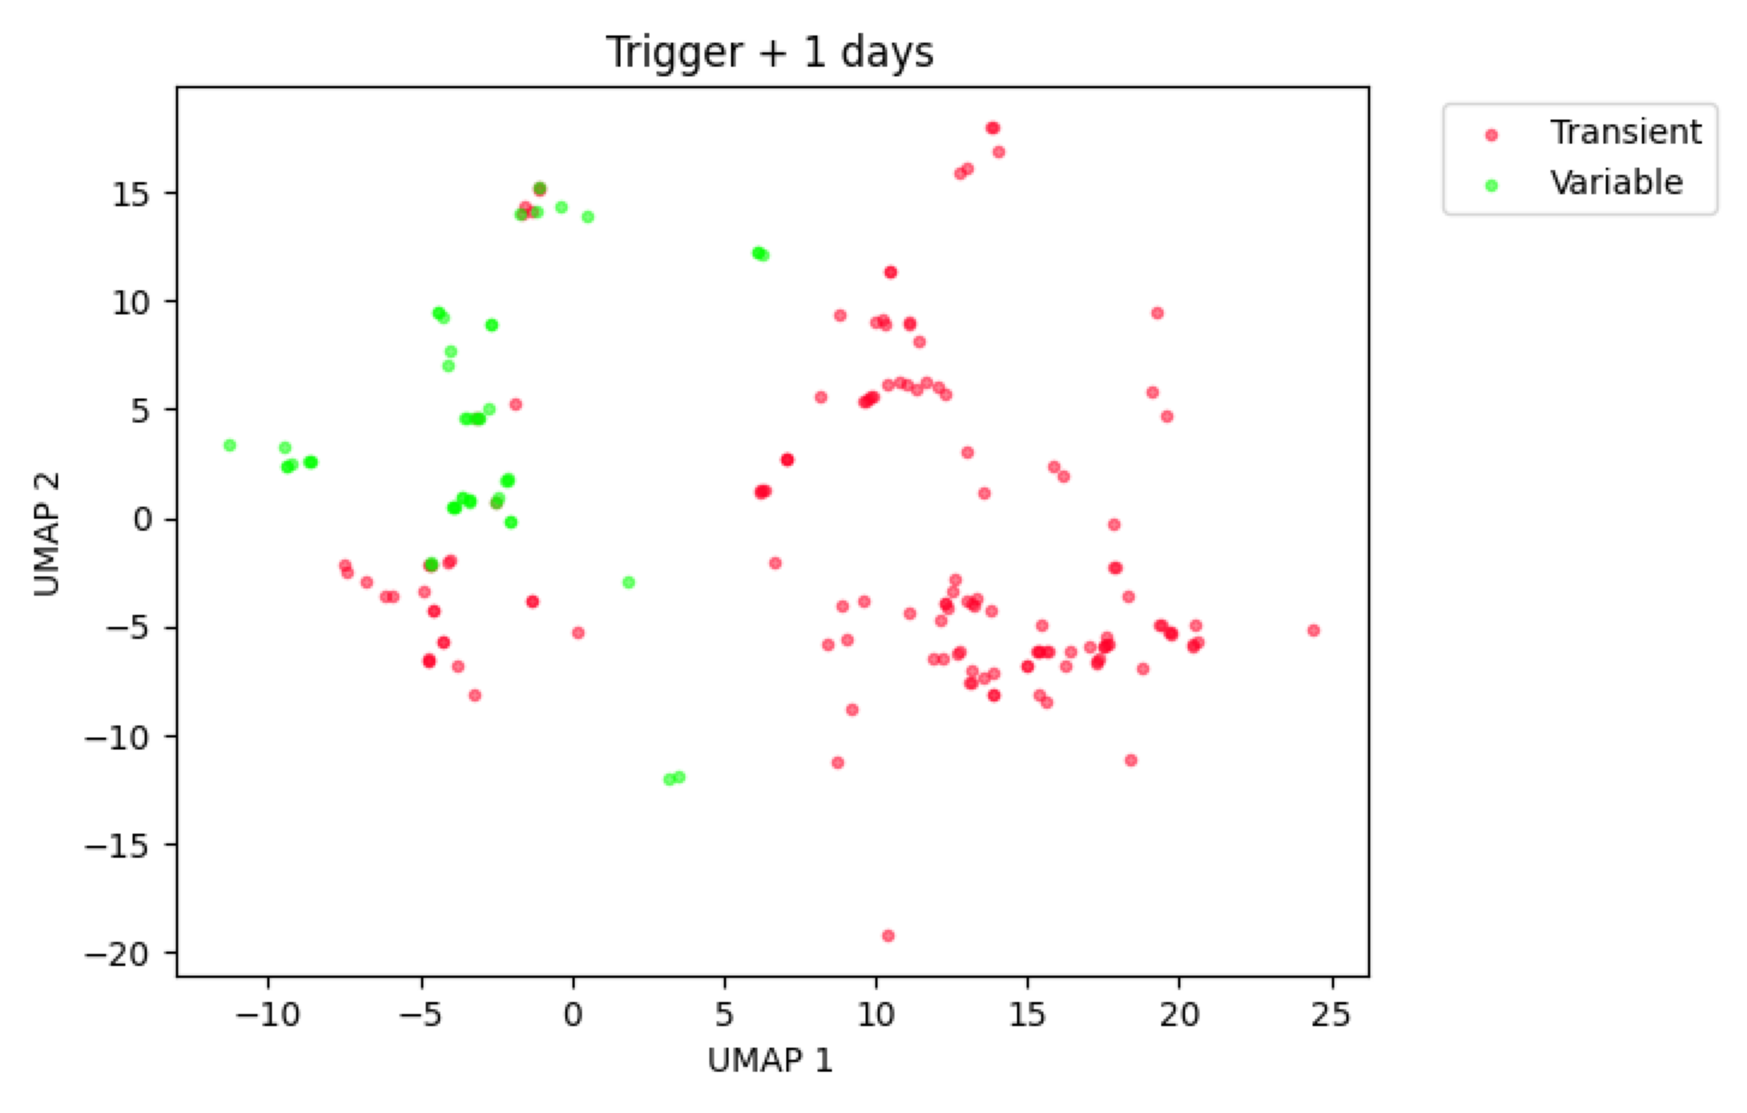

In [18]:
for i,d in enumerate(days):
    print(f"{d} Days after trigger")
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]
    for j, c in enumerate(np.unique(l1_labels)):
        
        idx = np.where(np.array(l1_labels)==c)

        plt.scatter(data_for_d[idx, 0], data_for_d[idx, 1], label=c, marker='.', color=color_arr[j*8], alpha=0.5)

        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Trigger + {d} days")
    plt.savefig(f"../Embedding_plots/level1_{d}.png",bbox_inches='tight')
    plt.show()

level1_embeddings = [f"../Embedding_plots/level1_{d}.png" for d in days]
make_gif(level1_embeddings, "../Embedding_plots/level1.gif")
plt.close()

# Looking for hierarchies

1 Days after trigger


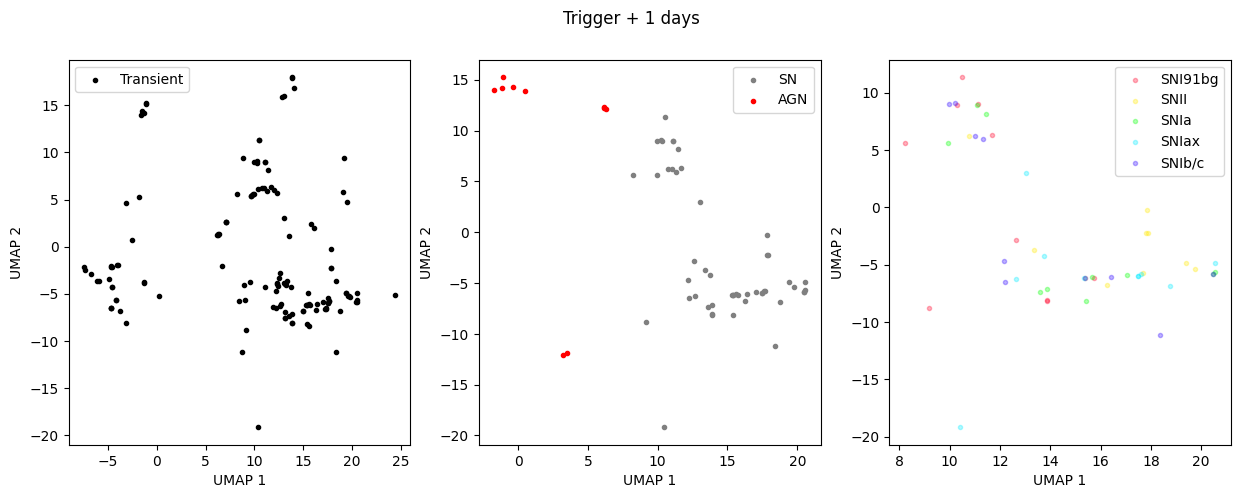

2 Days after trigger


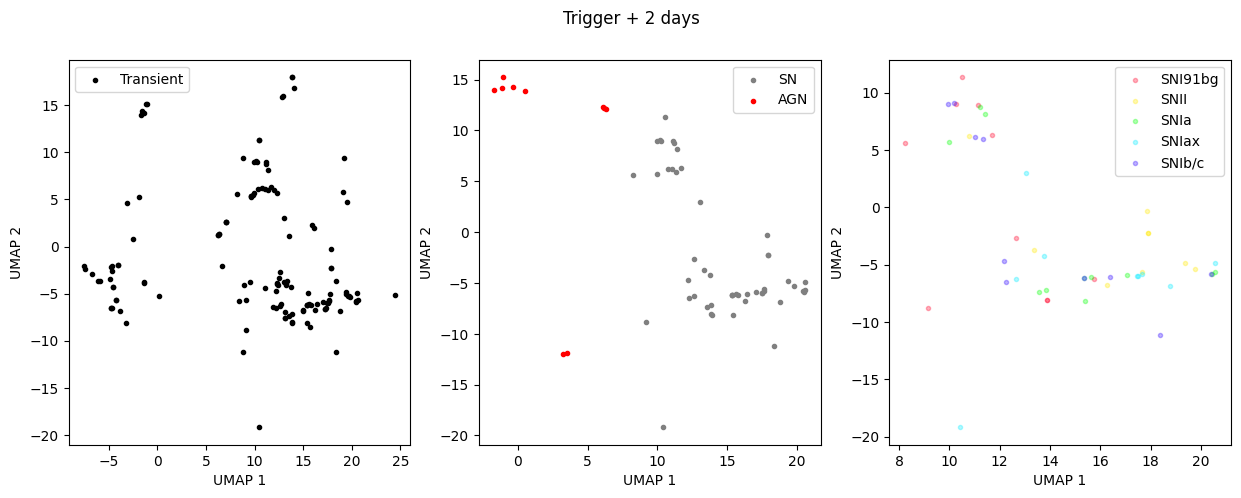

4 Days after trigger


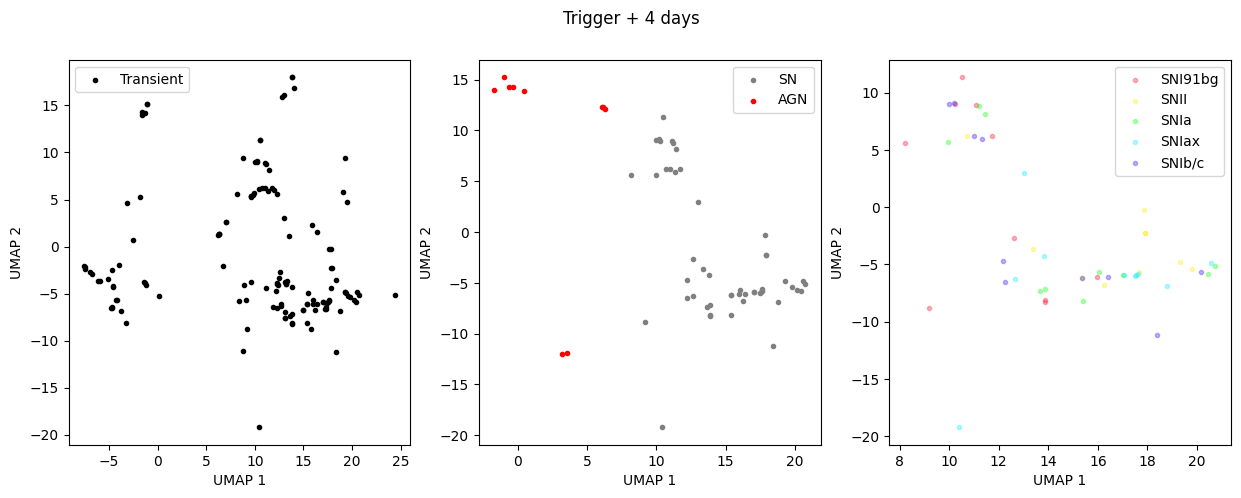

8 Days after trigger


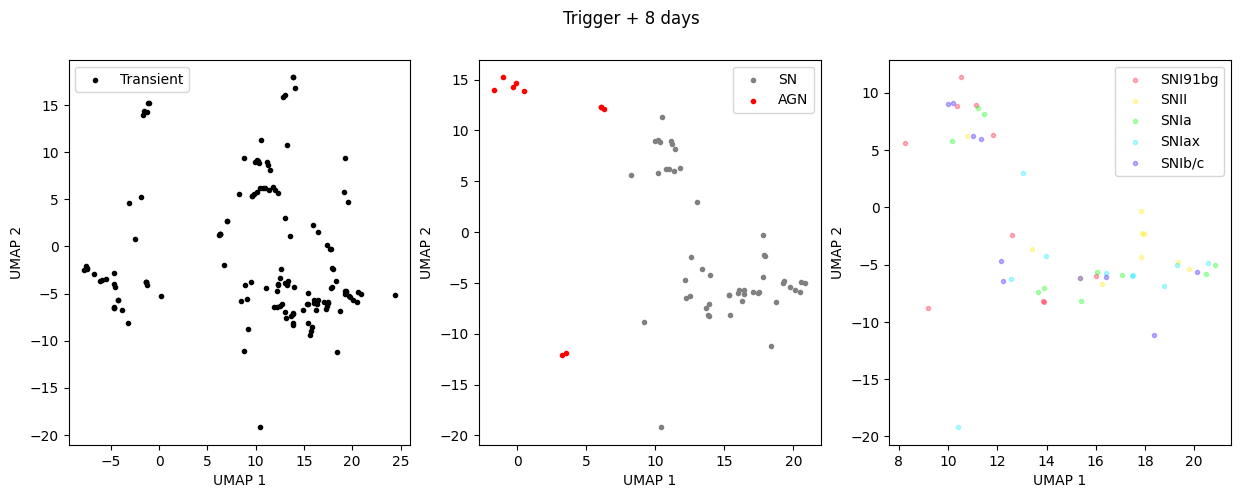

16 Days after trigger


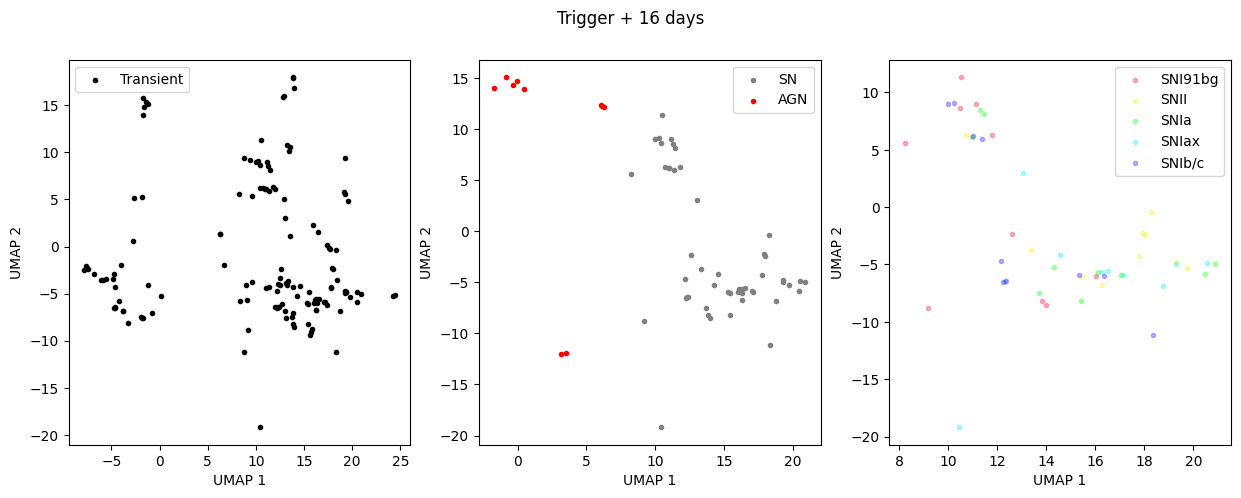

32 Days after trigger


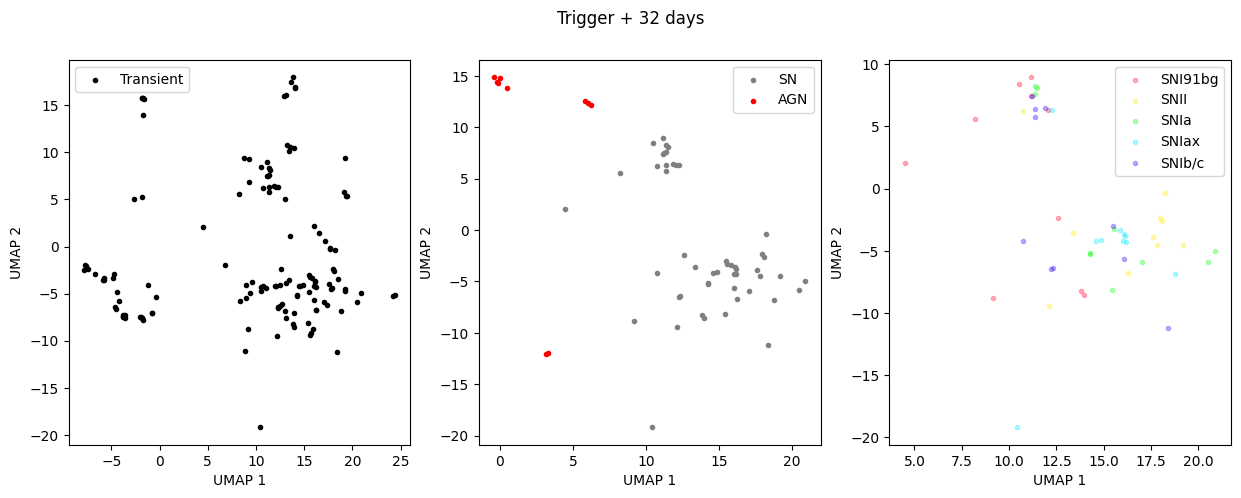

64 Days after trigger


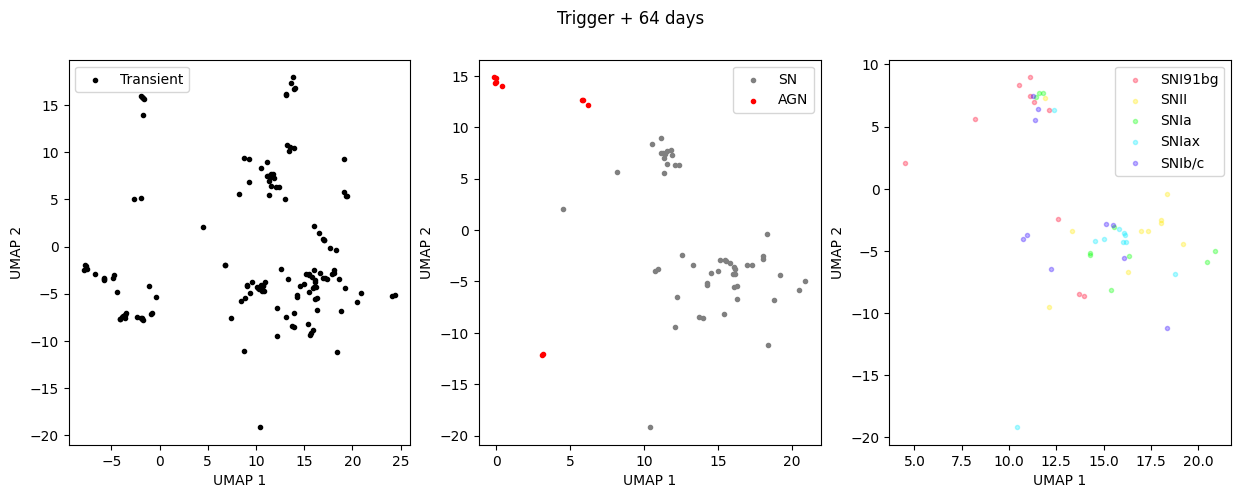

128 Days after trigger


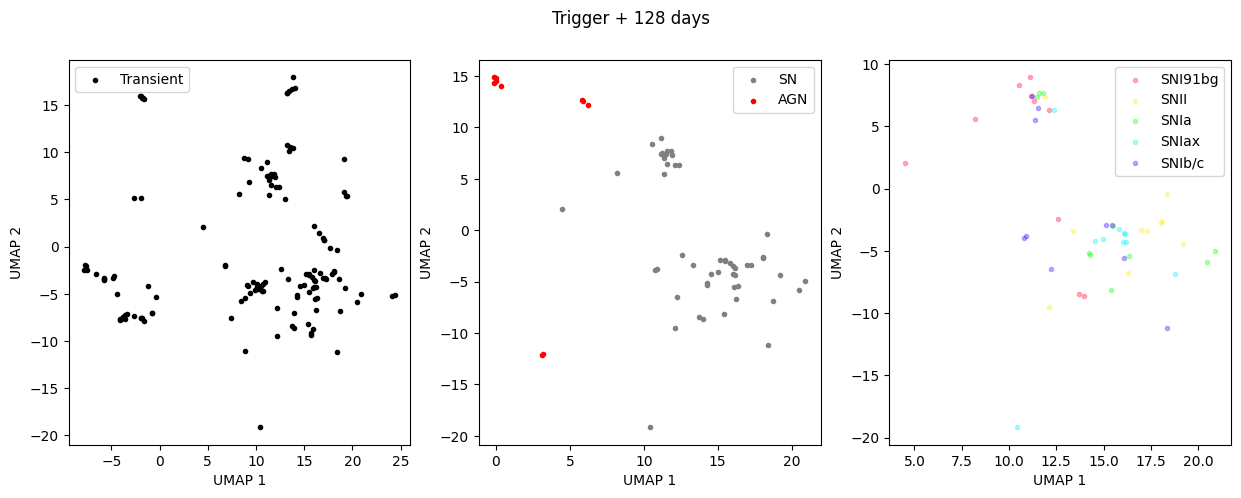

256 Days after trigger


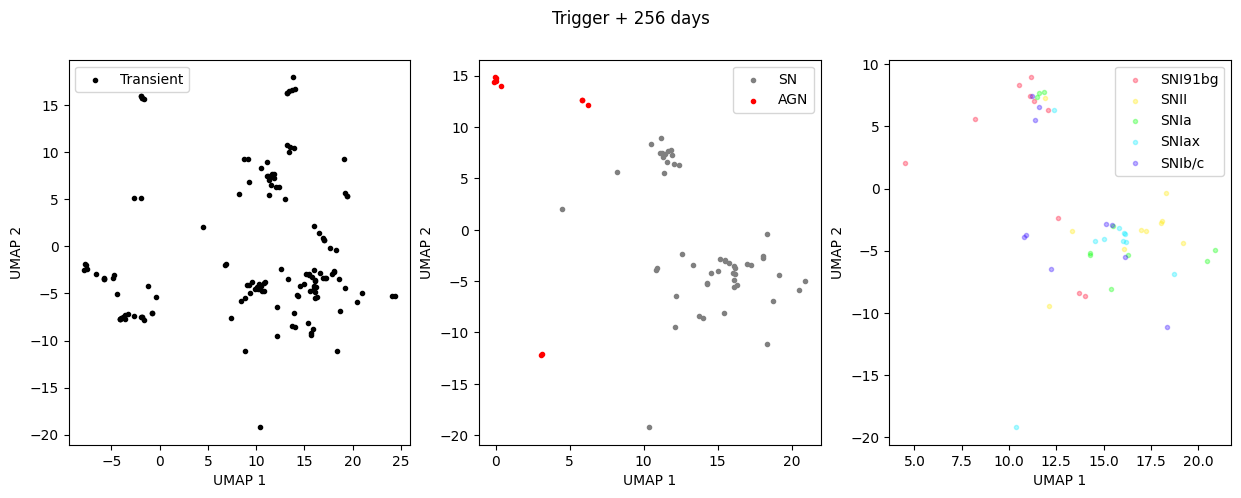

512 Days after trigger


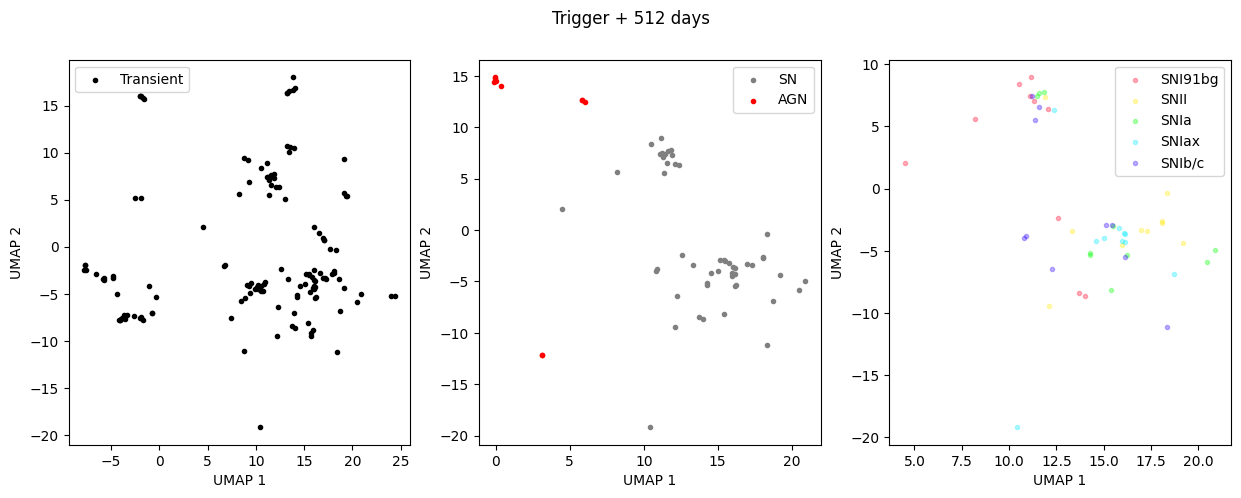

1024 Days after trigger


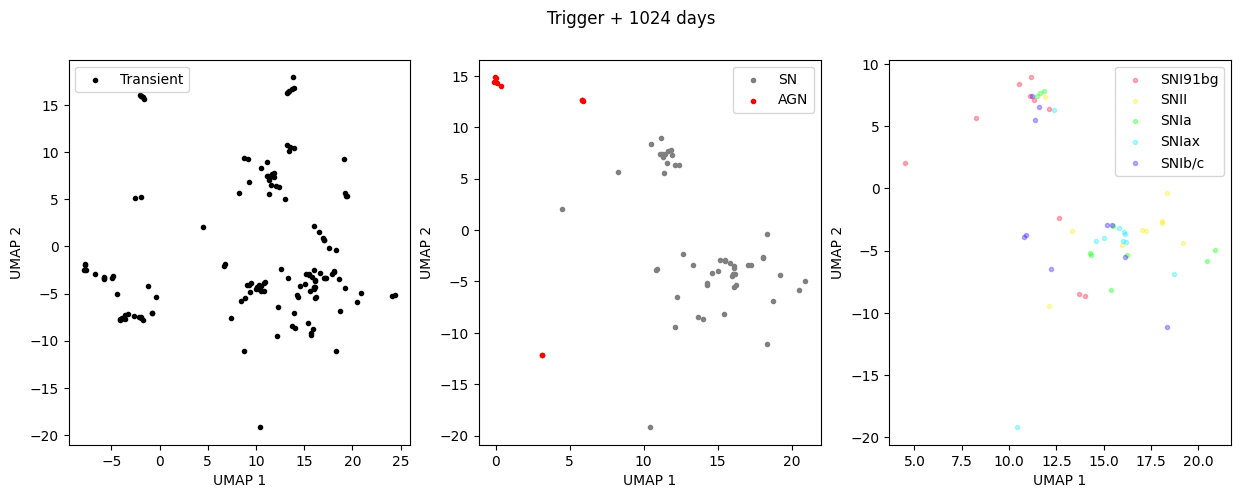

MovieWriter stderr:
dyld[28414]: Library not loaded: /opt/local/lib/libxcb.1.dylib
  Referenced from: <67E793D6-BC9B-38D4-8609-5815A4E33270> /Applications/mesasdk/bin/ffmpeg
  Reason: tried: '/opt/local/lib/libxcb.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libxcb.1.dylib' (no such file), '/opt/local/lib/libxcb.1.dylib' (no such file), '/usr/lib/libxcb.1.dylib' (no such file, not in dyld cache)



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x1800', '-pix_fmt', 'rgba', '-framerate', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', '../Embedding_plots/SN_hierarchy.gif']' died with <Signals.SIGABRT: 6>.

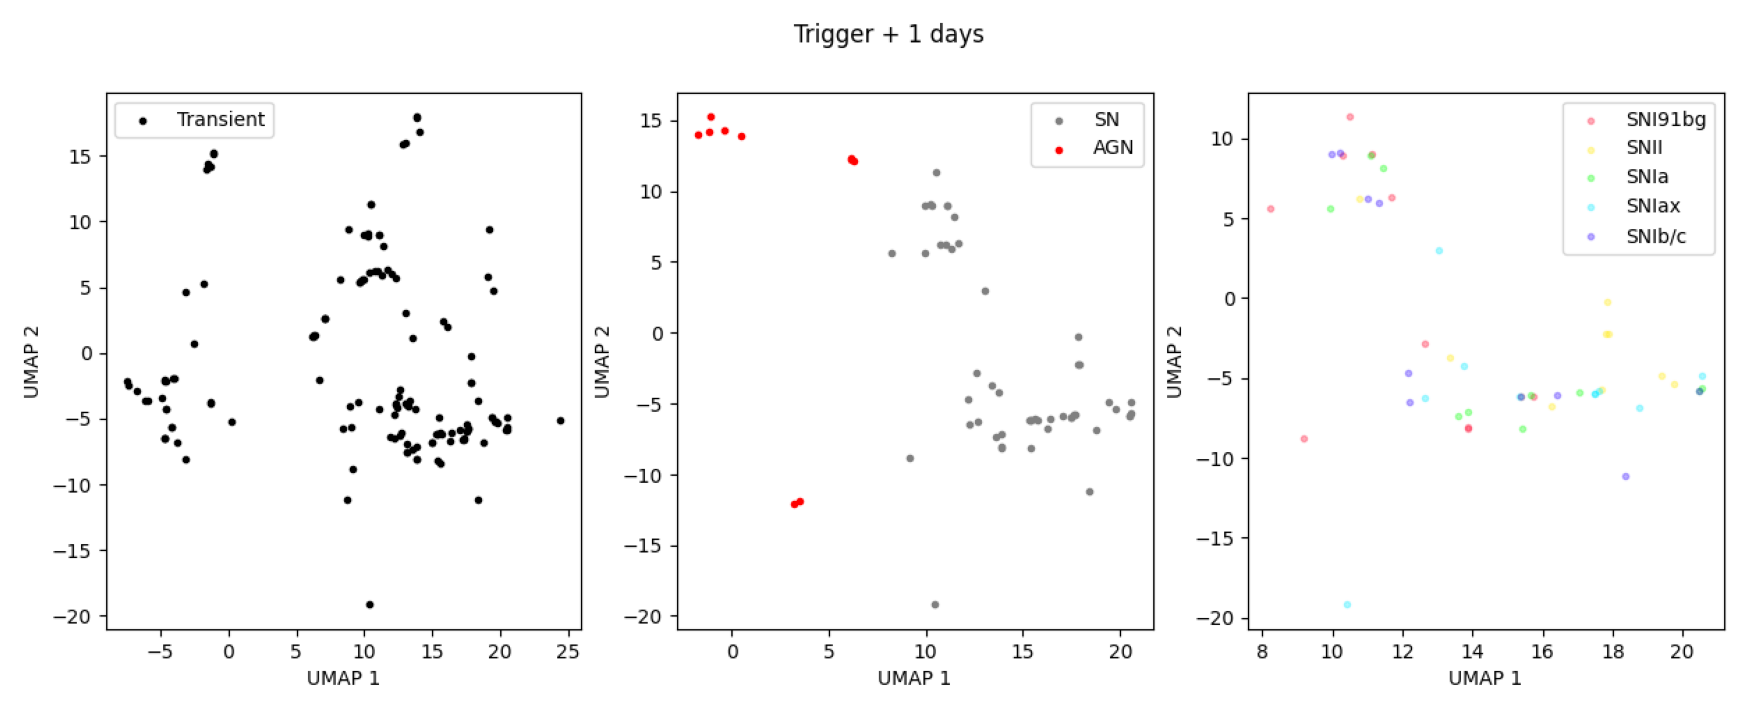

In [19]:
for i,d in enumerate(days):
    print(f"{d} Days after trigger")
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    transient_idx = np.where(np.array(l1_labels)=="Transient")

    axes[0].scatter(data_for_d[transient_idx, 0], data_for_d[transient_idx, 1], label="Transient", marker='.', color="Black")
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    axes[0].legend()


    sn_idx = np.where(np.array(l2_labels)=="SN")
    
    axes[1].scatter(data_for_d[sn_idx, 0], data_for_d[sn_idx, 1], label="SN", marker='.', color="Gray")
    
    agn_idx = np.where(np.array(l2_labels)=="AGN")
    
    axes[1].scatter(data_for_d[agn_idx, 0], data_for_d[agn_idx, 1], label="AGN", marker='.', color="Red")
    
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")
    axes[1].legend()
    
    sn_types = ['SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c']
    for j, s in enumerate(sn_types):
            
        idx = np.where(np.array(astrophysical_classes_balanced)==s)
        axes[2].scatter(data_for_d[idx, 0], data_for_d[idx, 1], label=s, marker='.', color=color_arr[j*4], alpha=0.3)
        

        axes[2].set_xlabel("UMAP 1")
        axes[2].set_ylabel("UMAP 2")
        axes[2].legend()
    fig.suptitle(f"Trigger + {d} days")
    plt.savefig(f"../Embedding_plots/SN_hierarchy{d}.png",bbox_inches='tight')


    plt.show()
    
SN_hierarchy_embeddings = [f"../Embedding_plots/SN_hierarchy{d}.png" for d in days]
make_gif(SN_hierarchy_embeddings, "../Embedding_plots/SN_hierarchy.gif")
plt.close()

1 Days after trigger


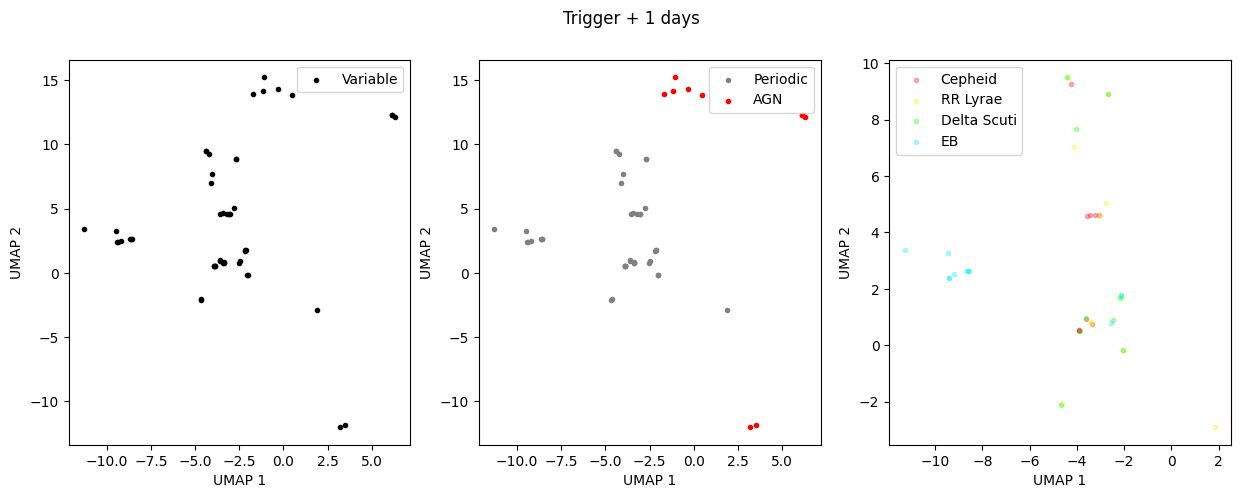

2 Days after trigger


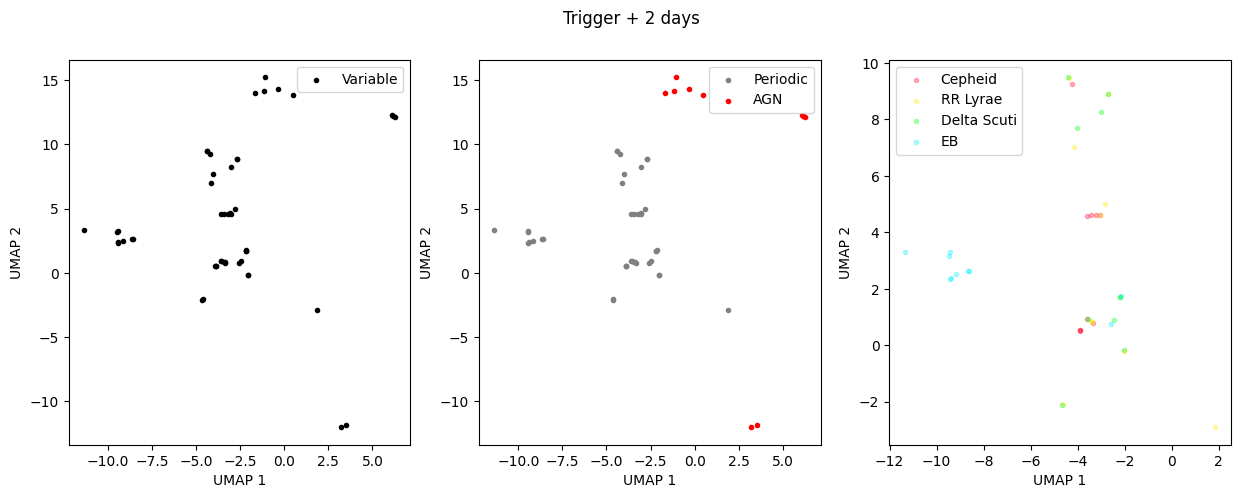

4 Days after trigger


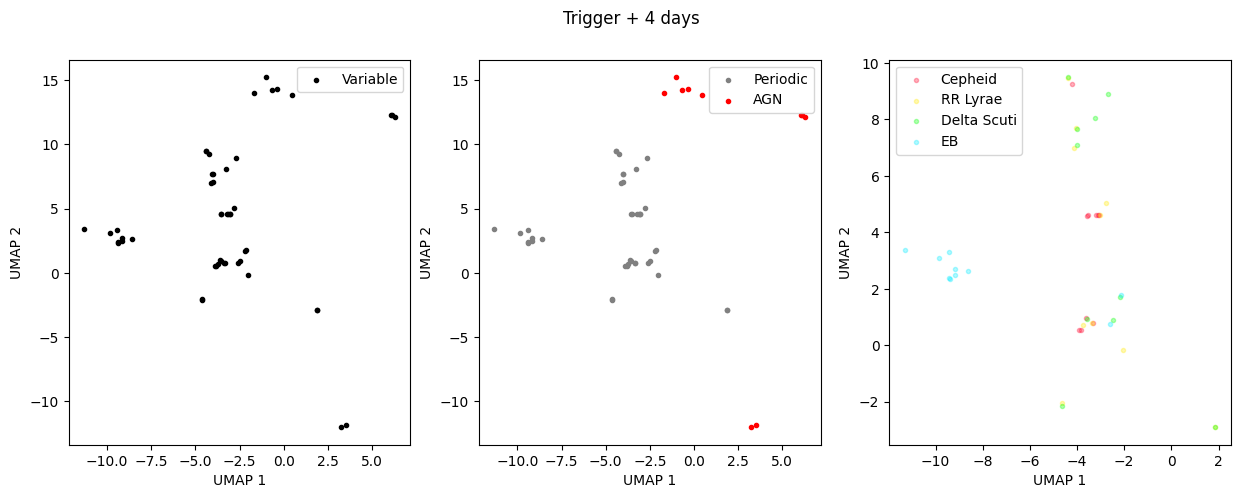

8 Days after trigger


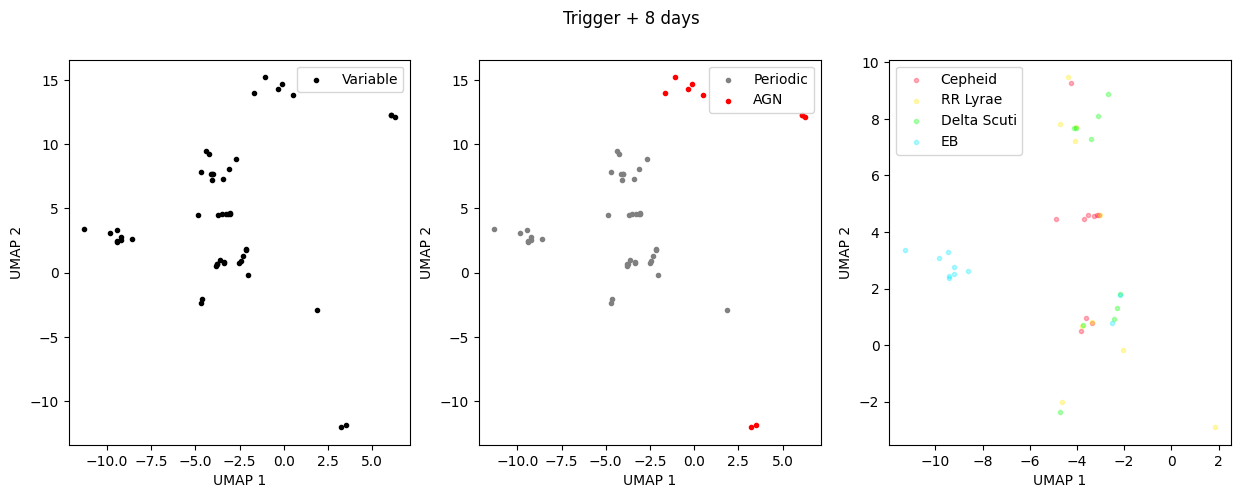

16 Days after trigger


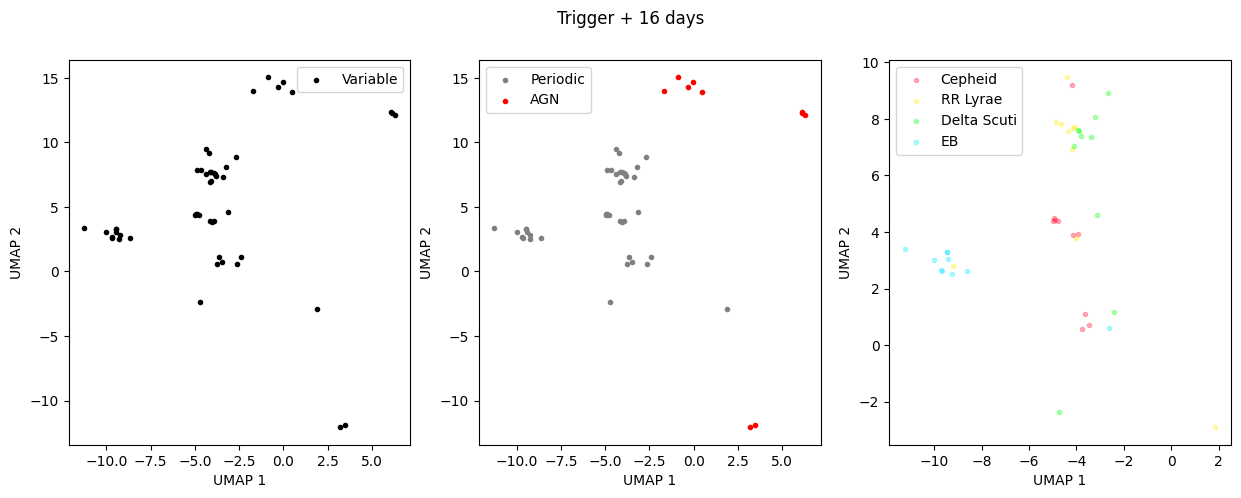

32 Days after trigger


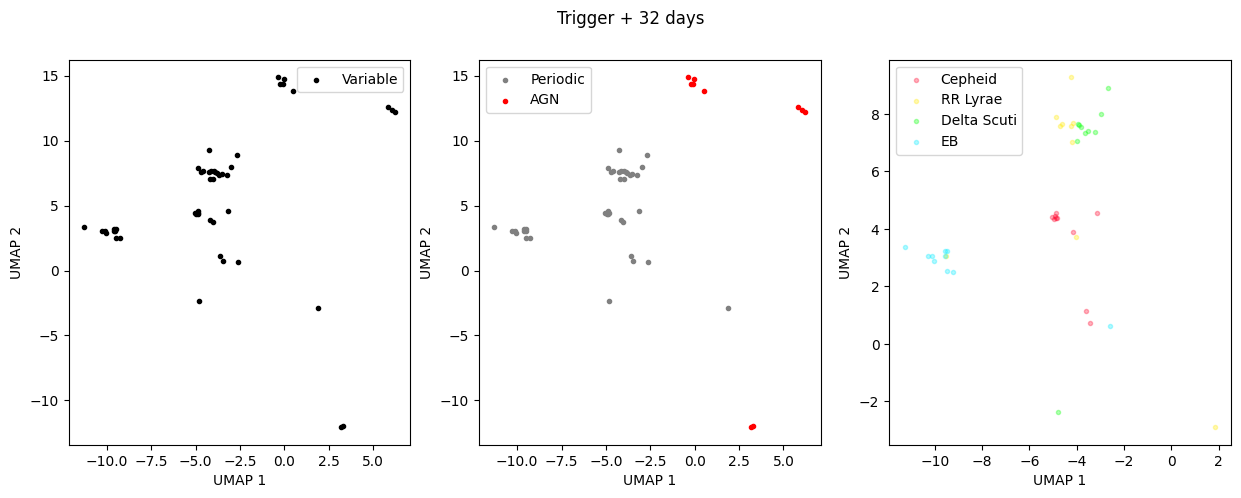

64 Days after trigger


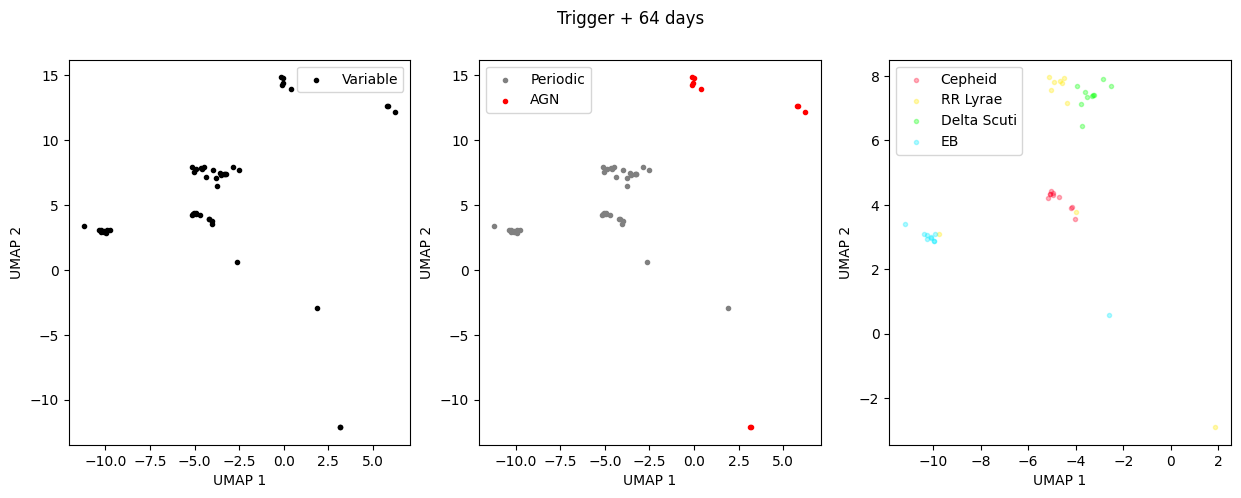

128 Days after trigger


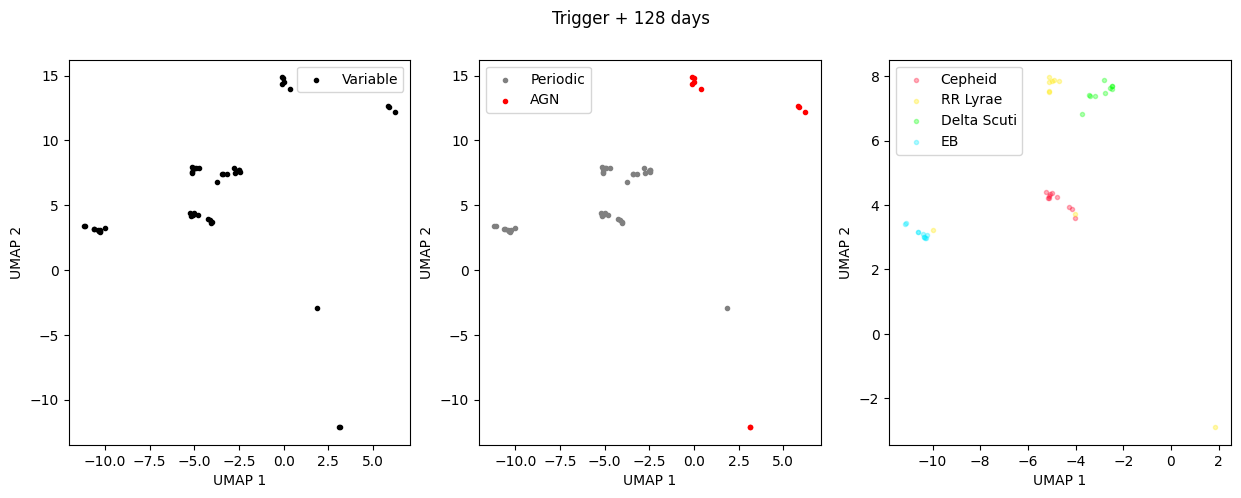

256 Days after trigger


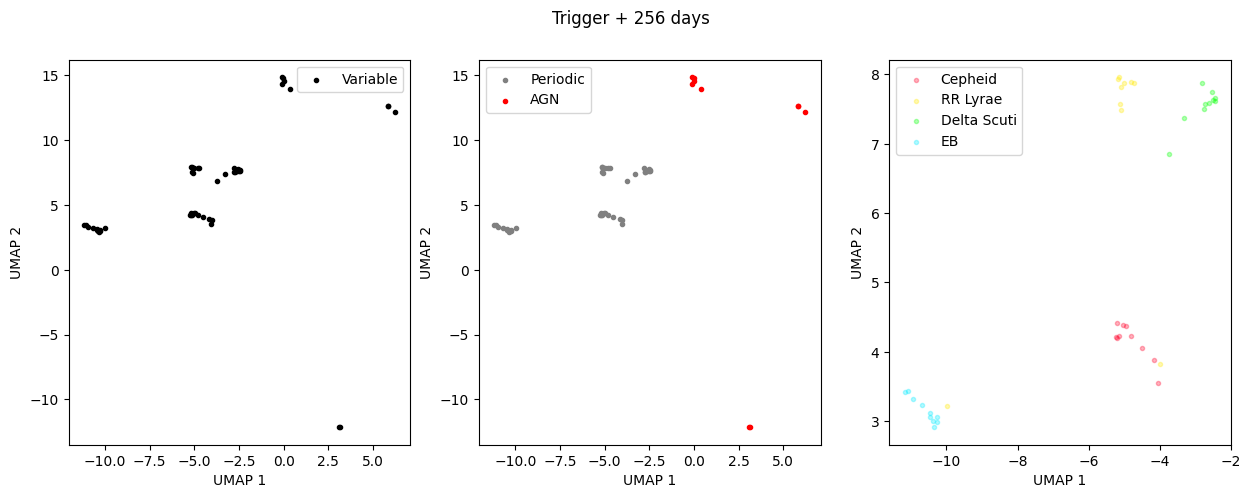

512 Days after trigger


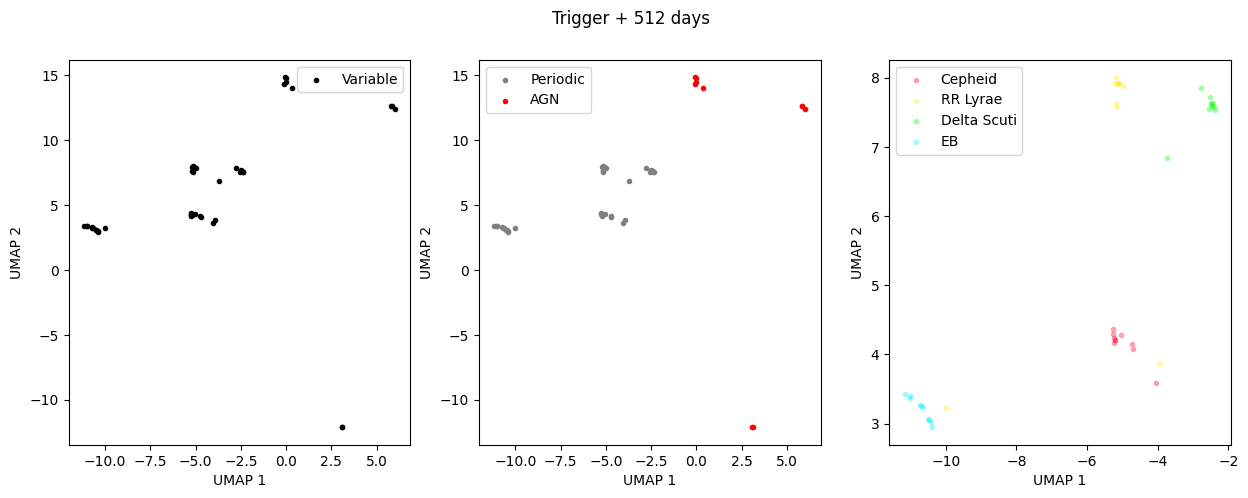

1024 Days after trigger


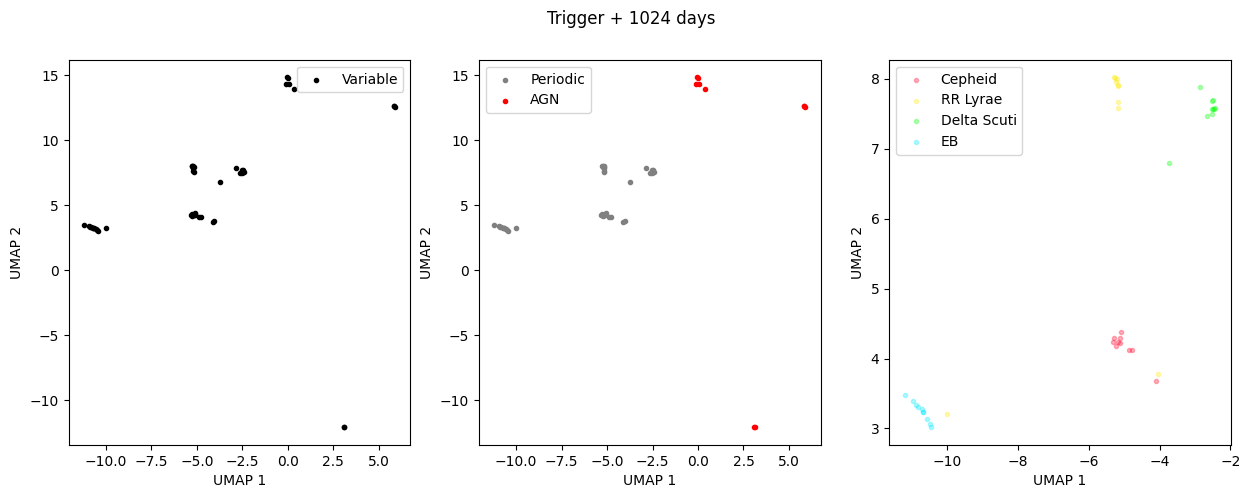

MovieWriter stderr:
dyld[28601]: Library not loaded: /opt/local/lib/libxcb.1.dylib
  Referenced from: <67E793D6-BC9B-38D4-8609-5815A4E33270> /Applications/mesasdk/bin/ffmpeg
  Reason: tried: '/opt/local/lib/libxcb.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libxcb.1.dylib' (no such file), '/opt/local/lib/libxcb.1.dylib' (no such file), '/usr/lib/libxcb.1.dylib' (no such file, not in dyld cache)



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x1800', '-pix_fmt', 'rgba', '-framerate', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', '../Embedding_plots/Periodic_hierarchy.gif']' died with <Signals.SIGABRT: 6>.

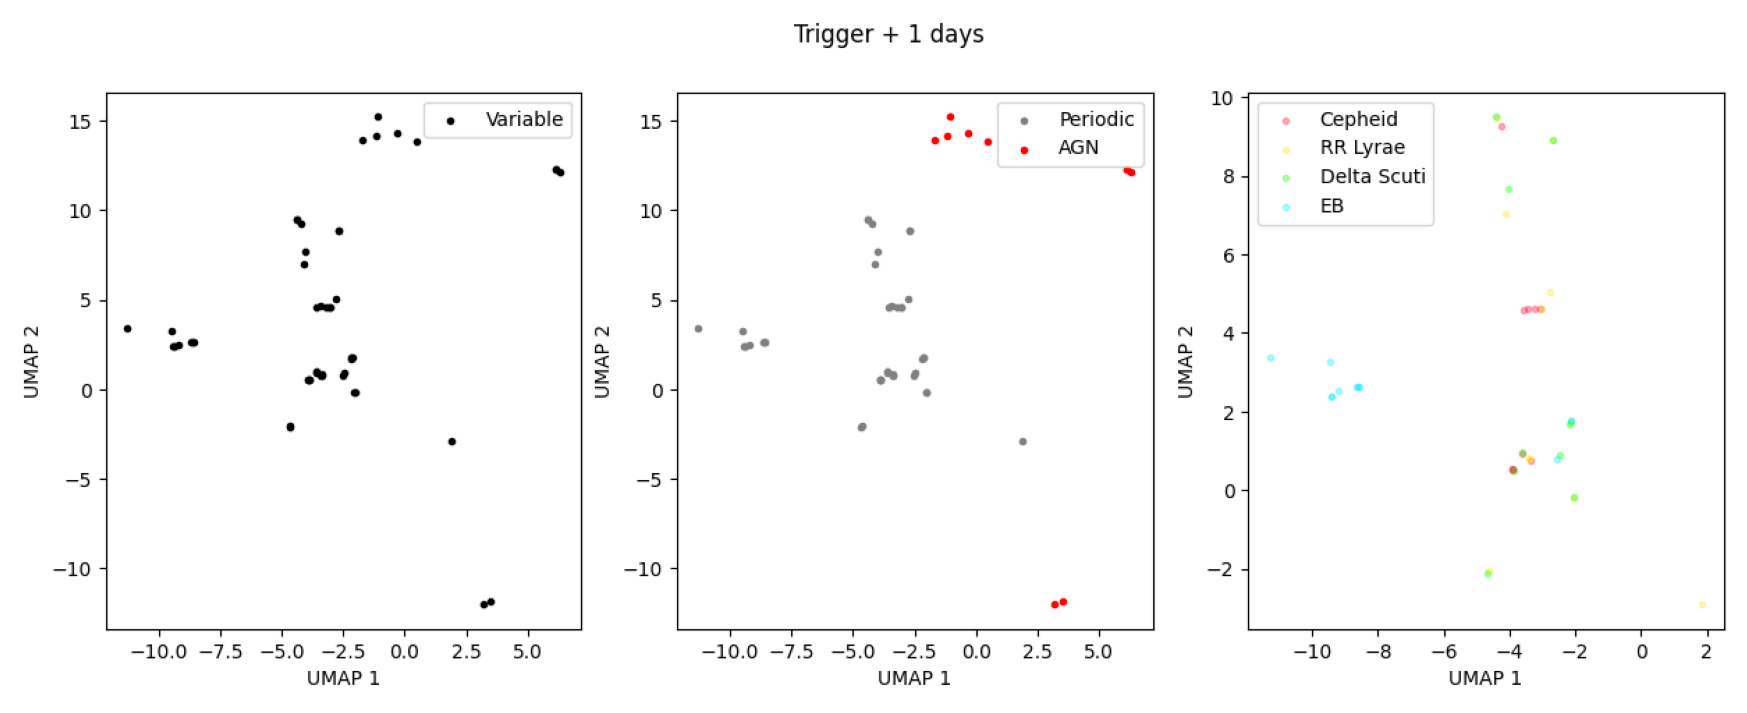

In [20]:
for i,d in enumerate(days):
    print(f"{d} Days after trigger")
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    variable_idx = np.where(np.array(l1_labels)=="Variable")

    axes[0].scatter(data_for_d[variable_idx, 0], data_for_d[variable_idx, 1], label="Variable", marker='.', color="Black")
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    axes[0].legend()


    sn_idx = np.where(np.array(l2_labels)=="Periodic")
    
    axes[1].scatter(data_for_d[sn_idx, 0], data_for_d[sn_idx, 1], label="Periodic", marker='.', color="Gray")

    agn_idx = np.where(np.array(l2_labels)=="AGN")
    
    axes[1].scatter(data_for_d[agn_idx, 0], data_for_d[agn_idx, 1], label="AGN", marker='.', color="Red")
    
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")
    axes[1].legend()
    
    sn_types = ['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB']
    for j, s in enumerate(sn_types):
            
        idx = np.where(np.array(astrophysical_classes_balanced)==s)
        axes[2].scatter(data_for_d[idx, 0], data_for_d[idx, 1], label=s, marker='.', color=color_arr[j*4], alpha=0.3)
        

        axes[2].set_xlabel("UMAP 1")
        axes[2].set_ylabel("UMAP 2")
        axes[2].legend()
    fig.suptitle(f"Trigger + {d} days")
    plt.savefig(f"../Embedding_plots/Periodic_hierarchy{d}.png",bbox_inches='tight')


    plt.show()
    
periodic_hierarchy_embeddings = [f"../Embedding_plots/Periodic_hierarchy{d}.png" for d in days]
make_gif(periodic_hierarchy_embeddings, "../Embedding_plots/Periodic_hierarchy.gif")
plt.close()

1 Days after trigger


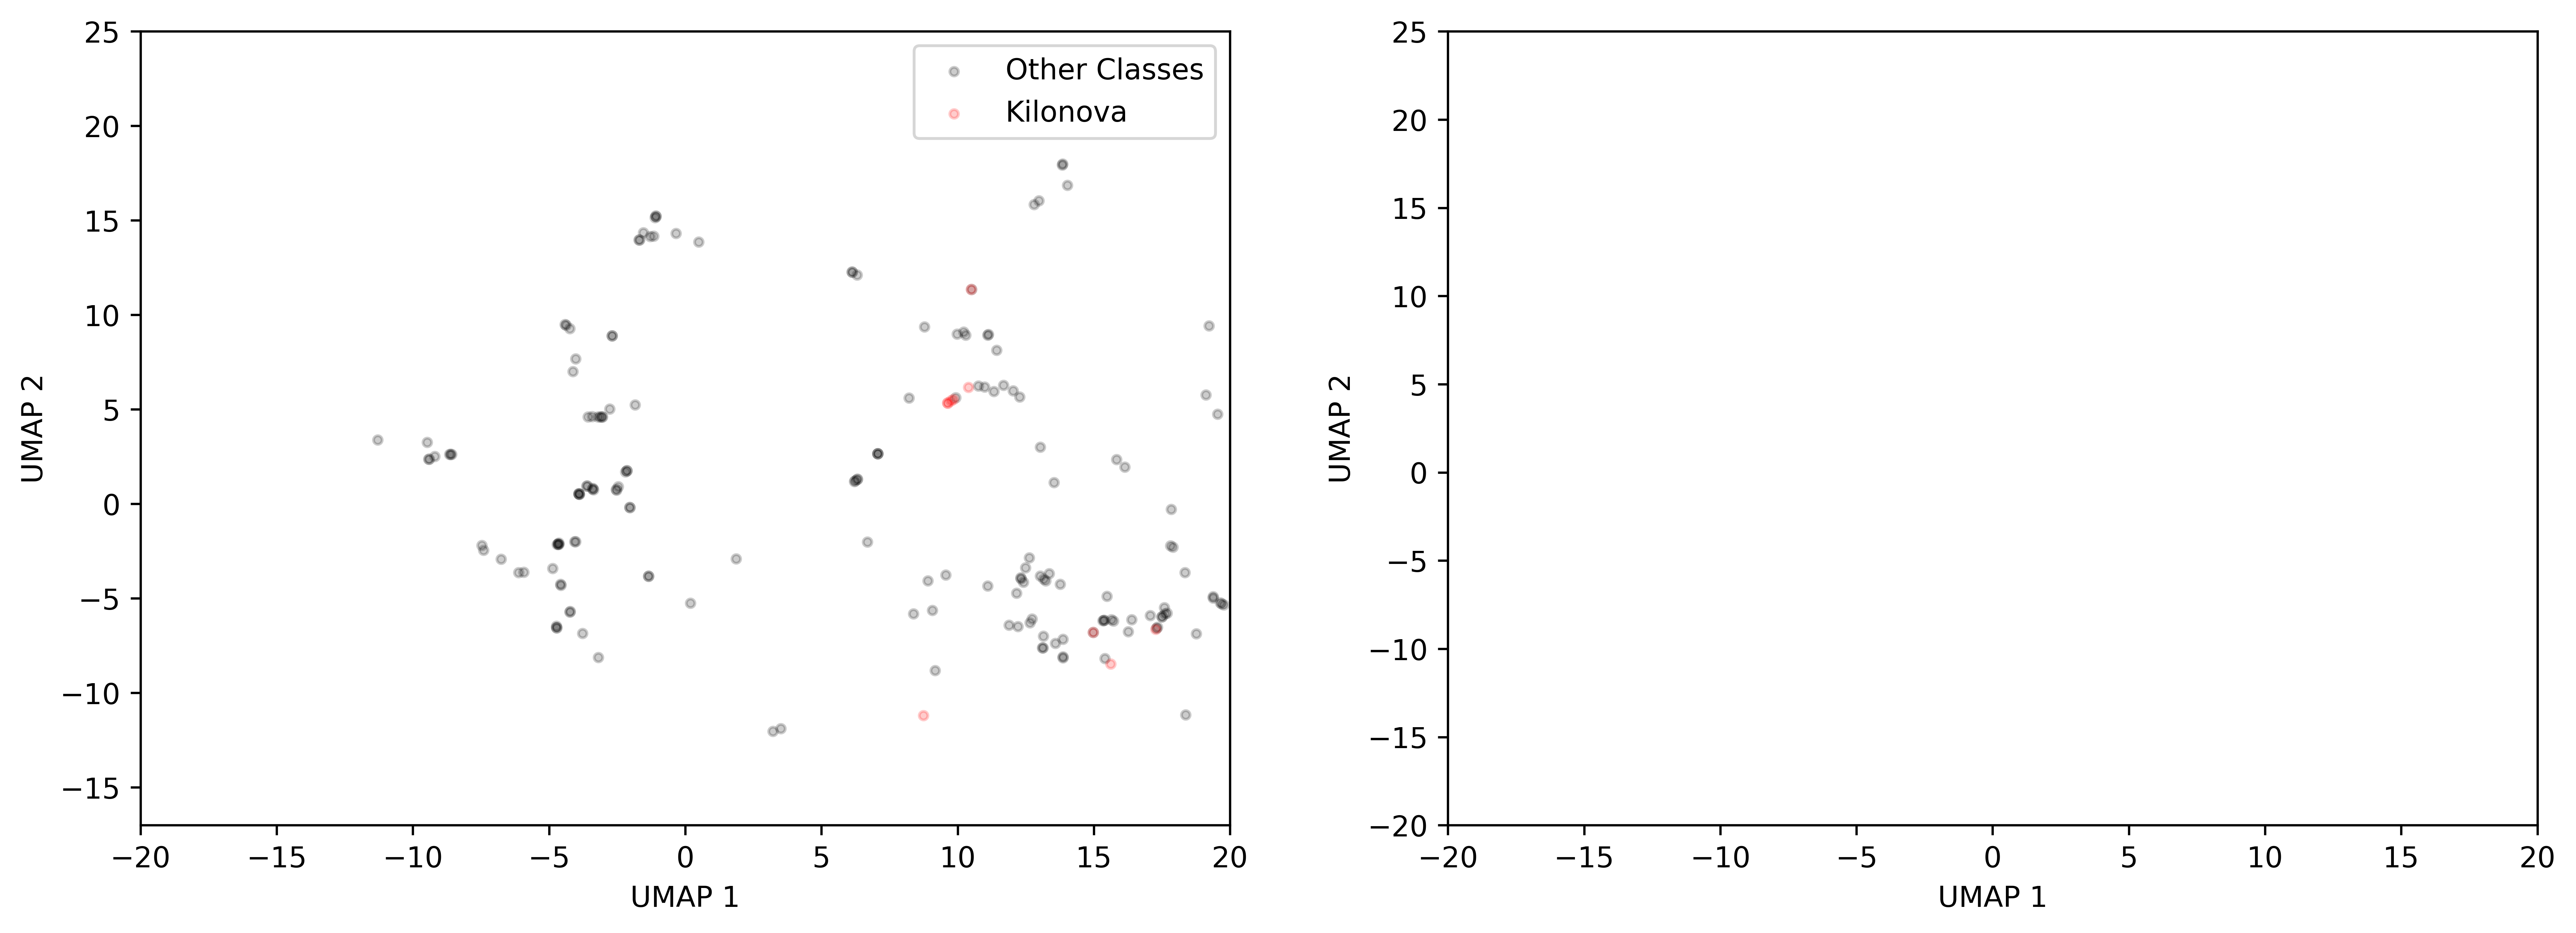

2 Days after trigger


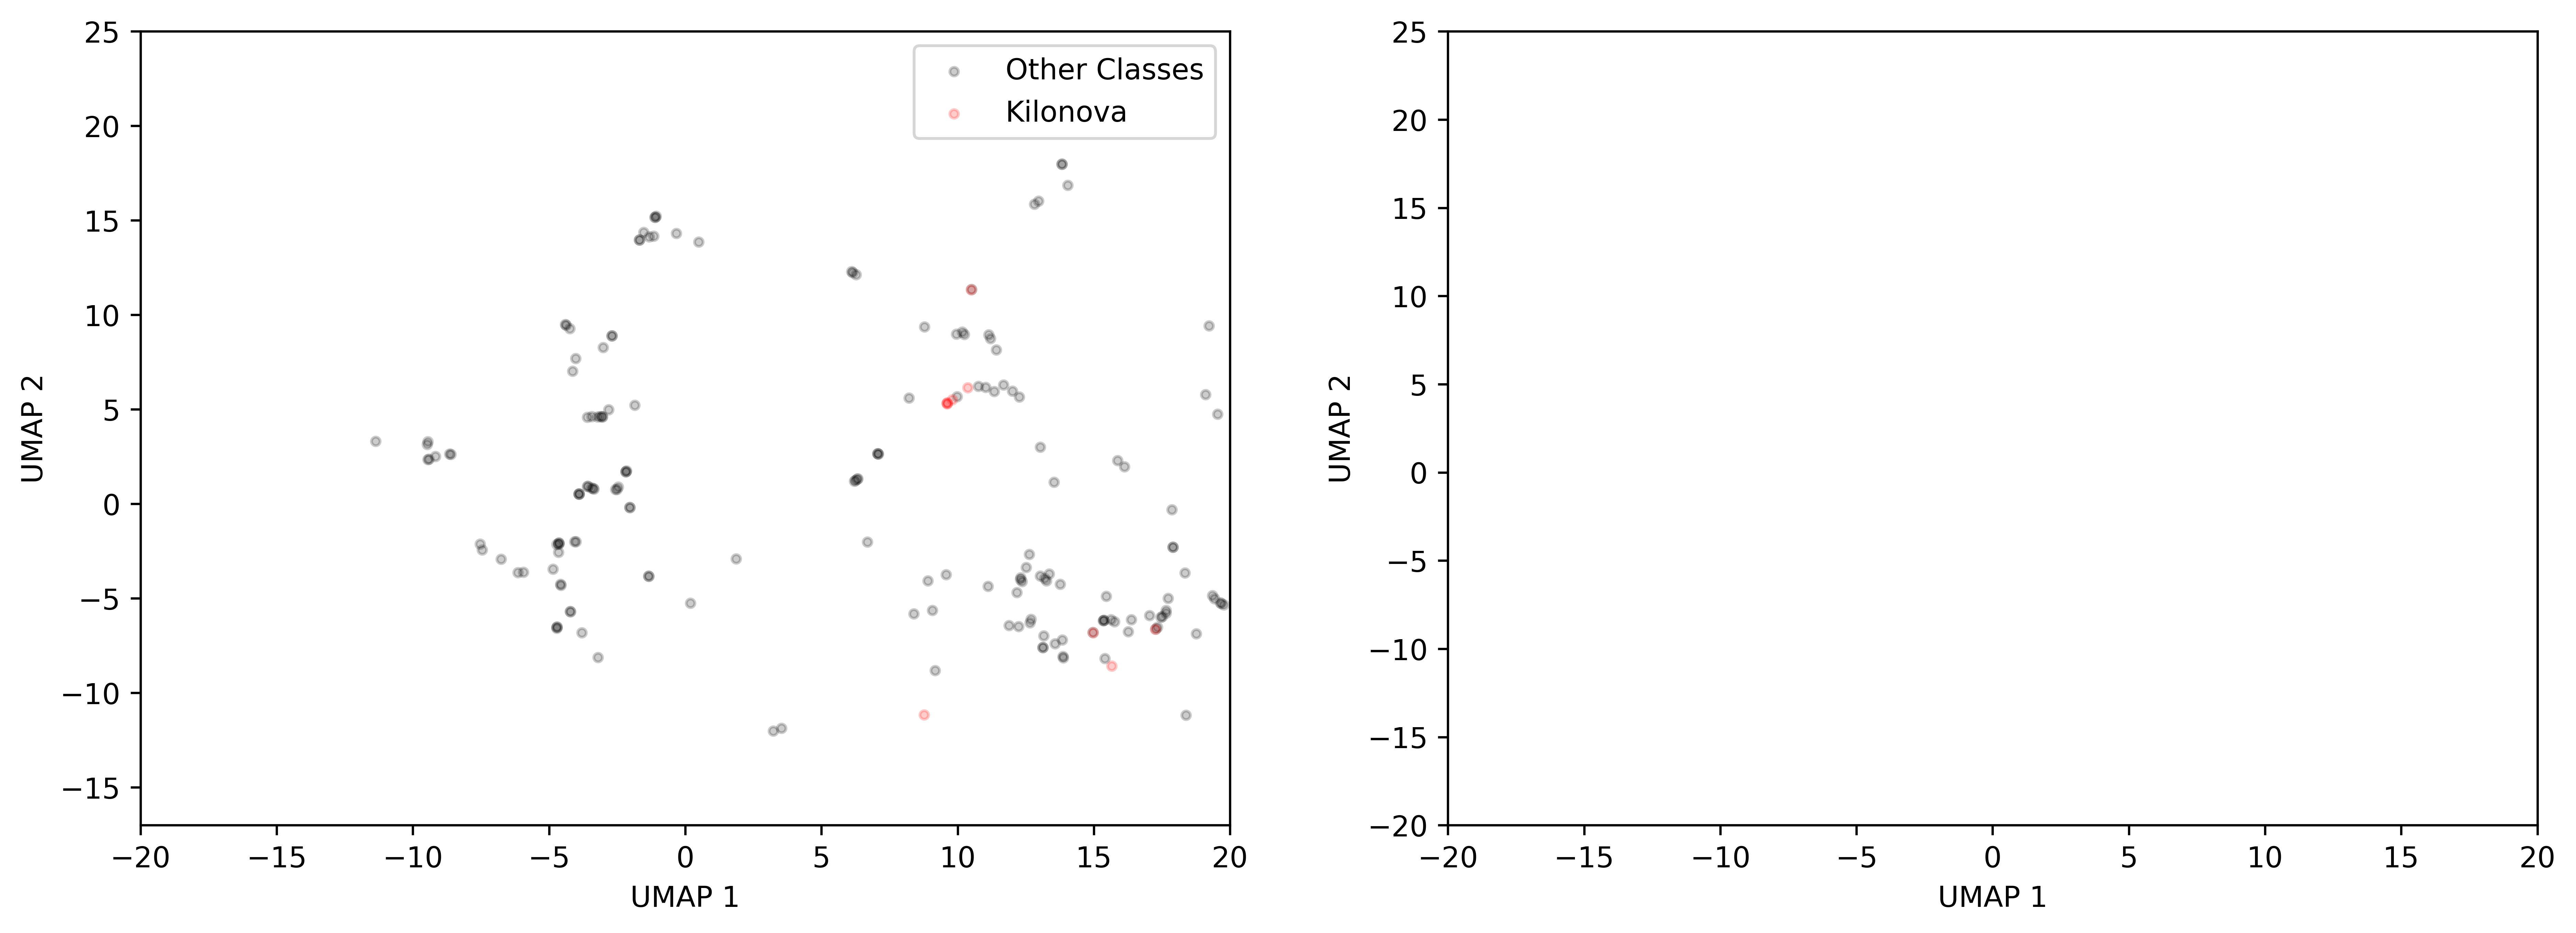

4 Days after trigger


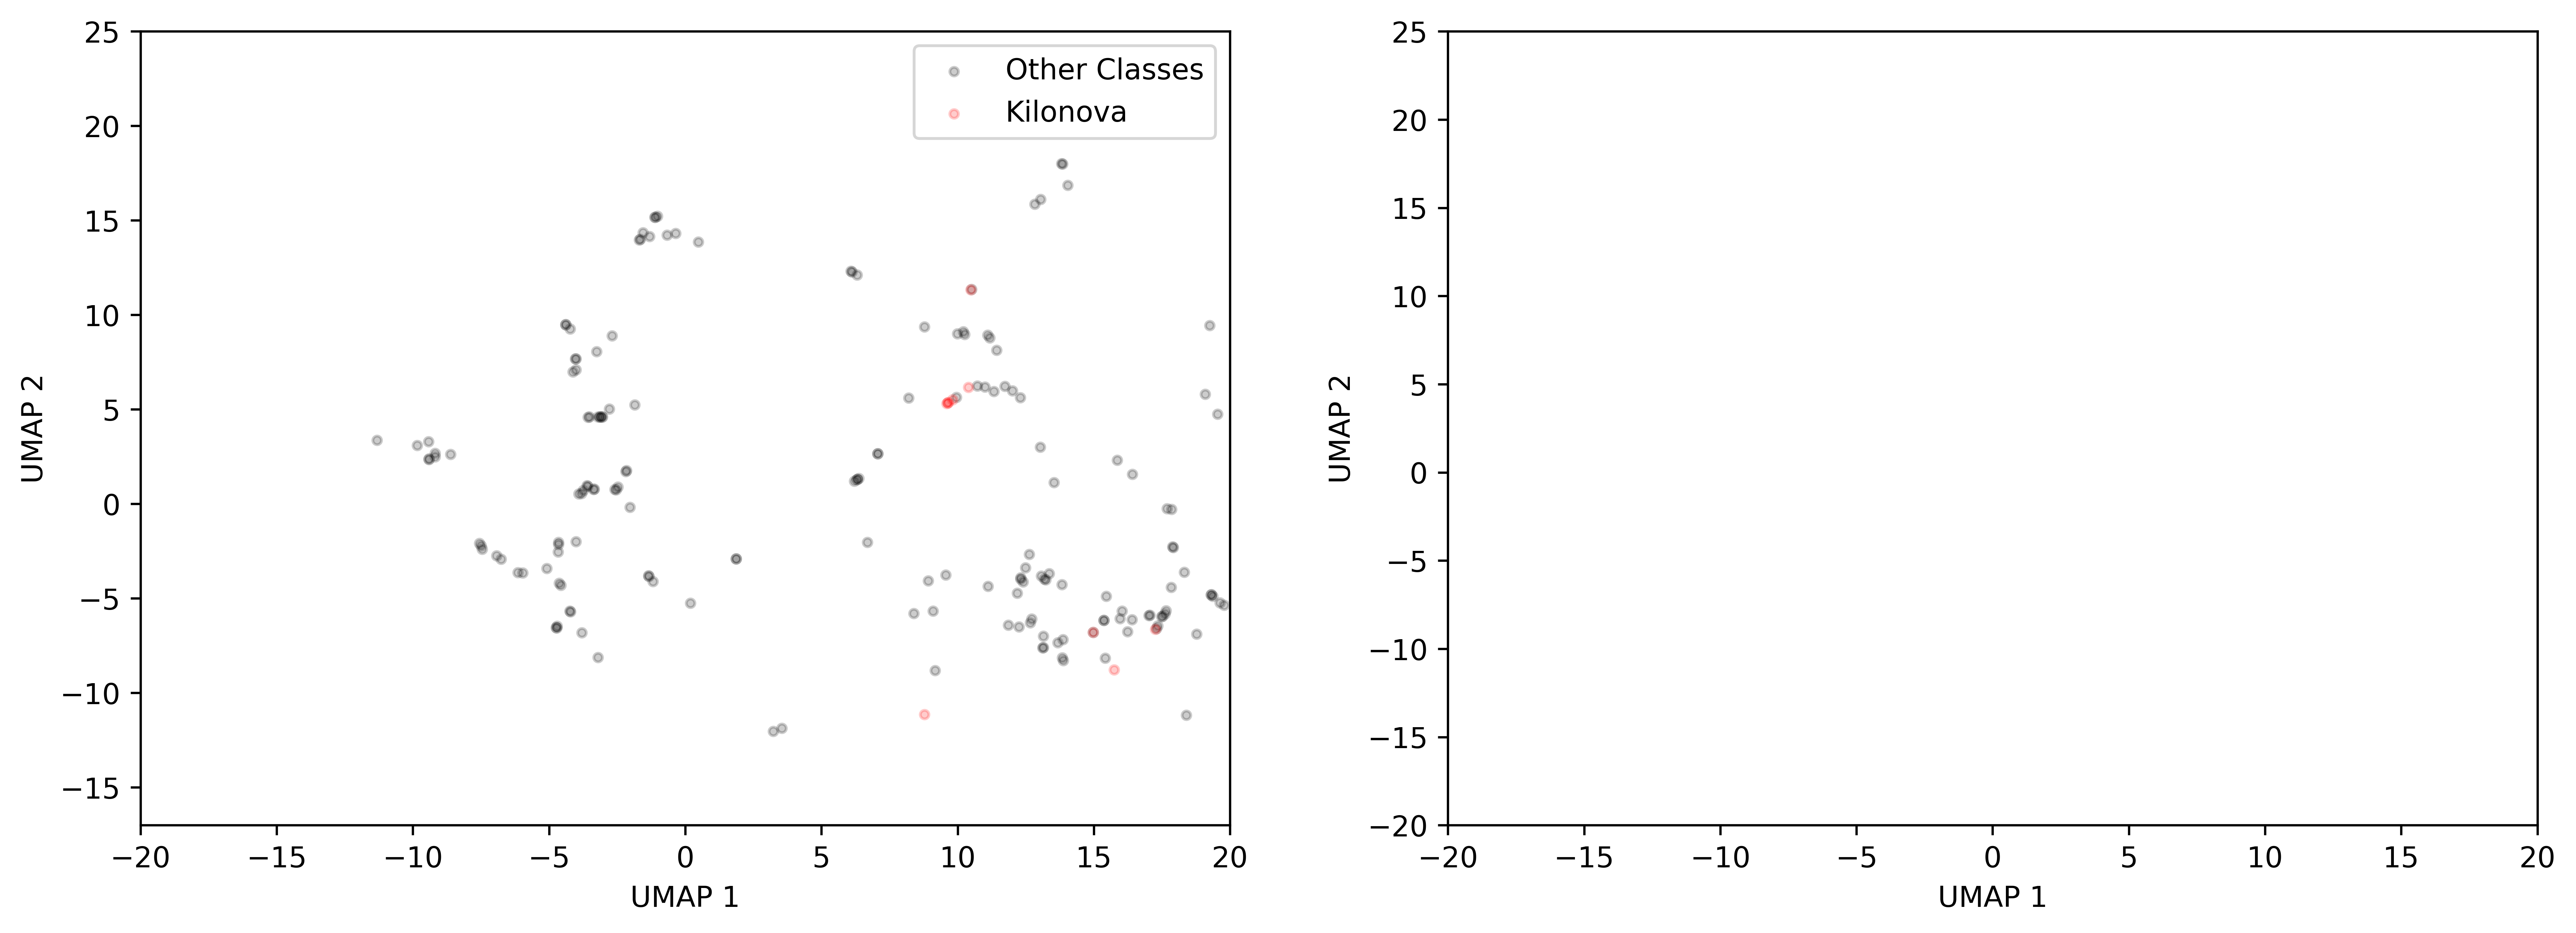

8 Days after trigger


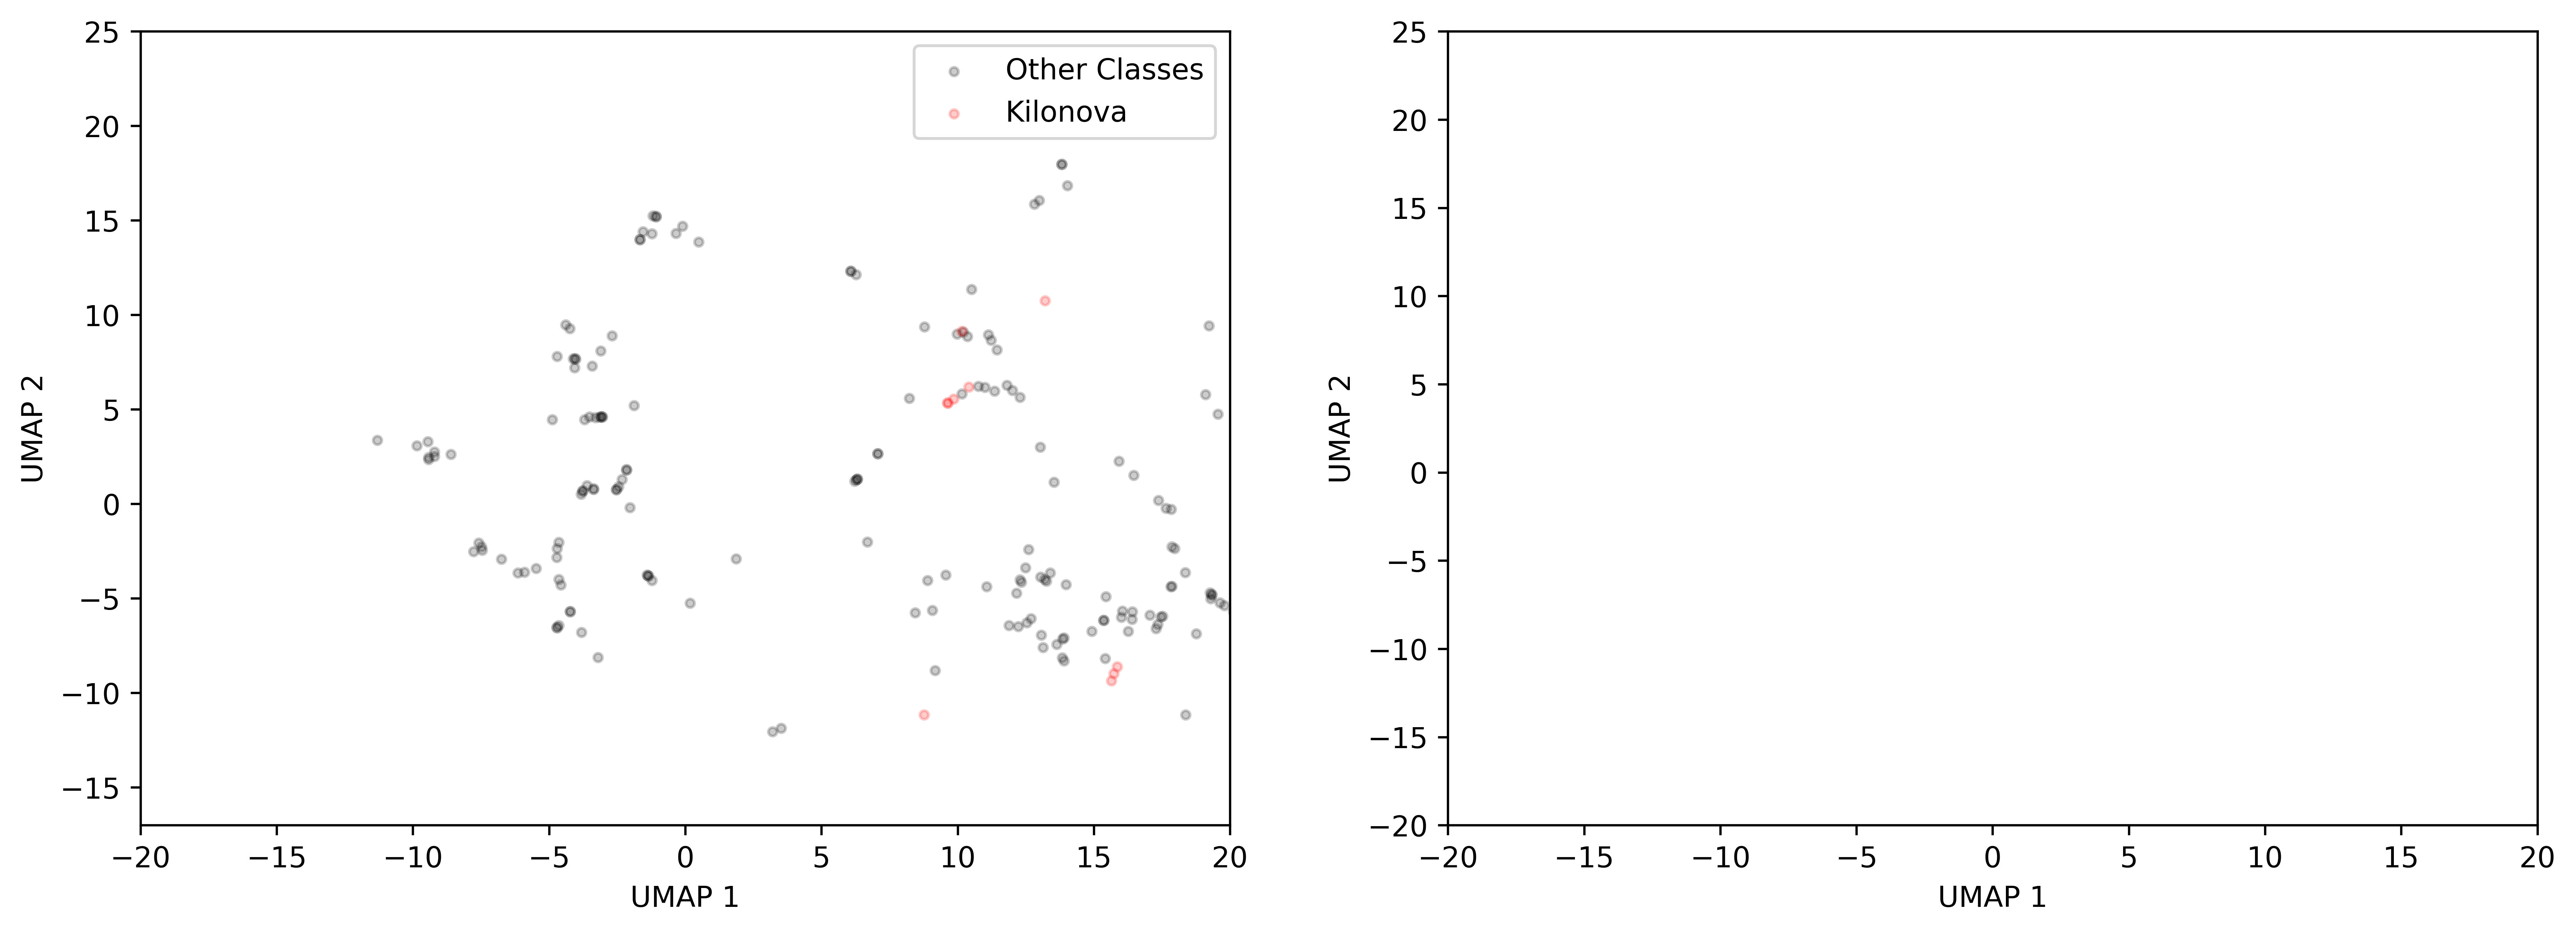

16 Days after trigger


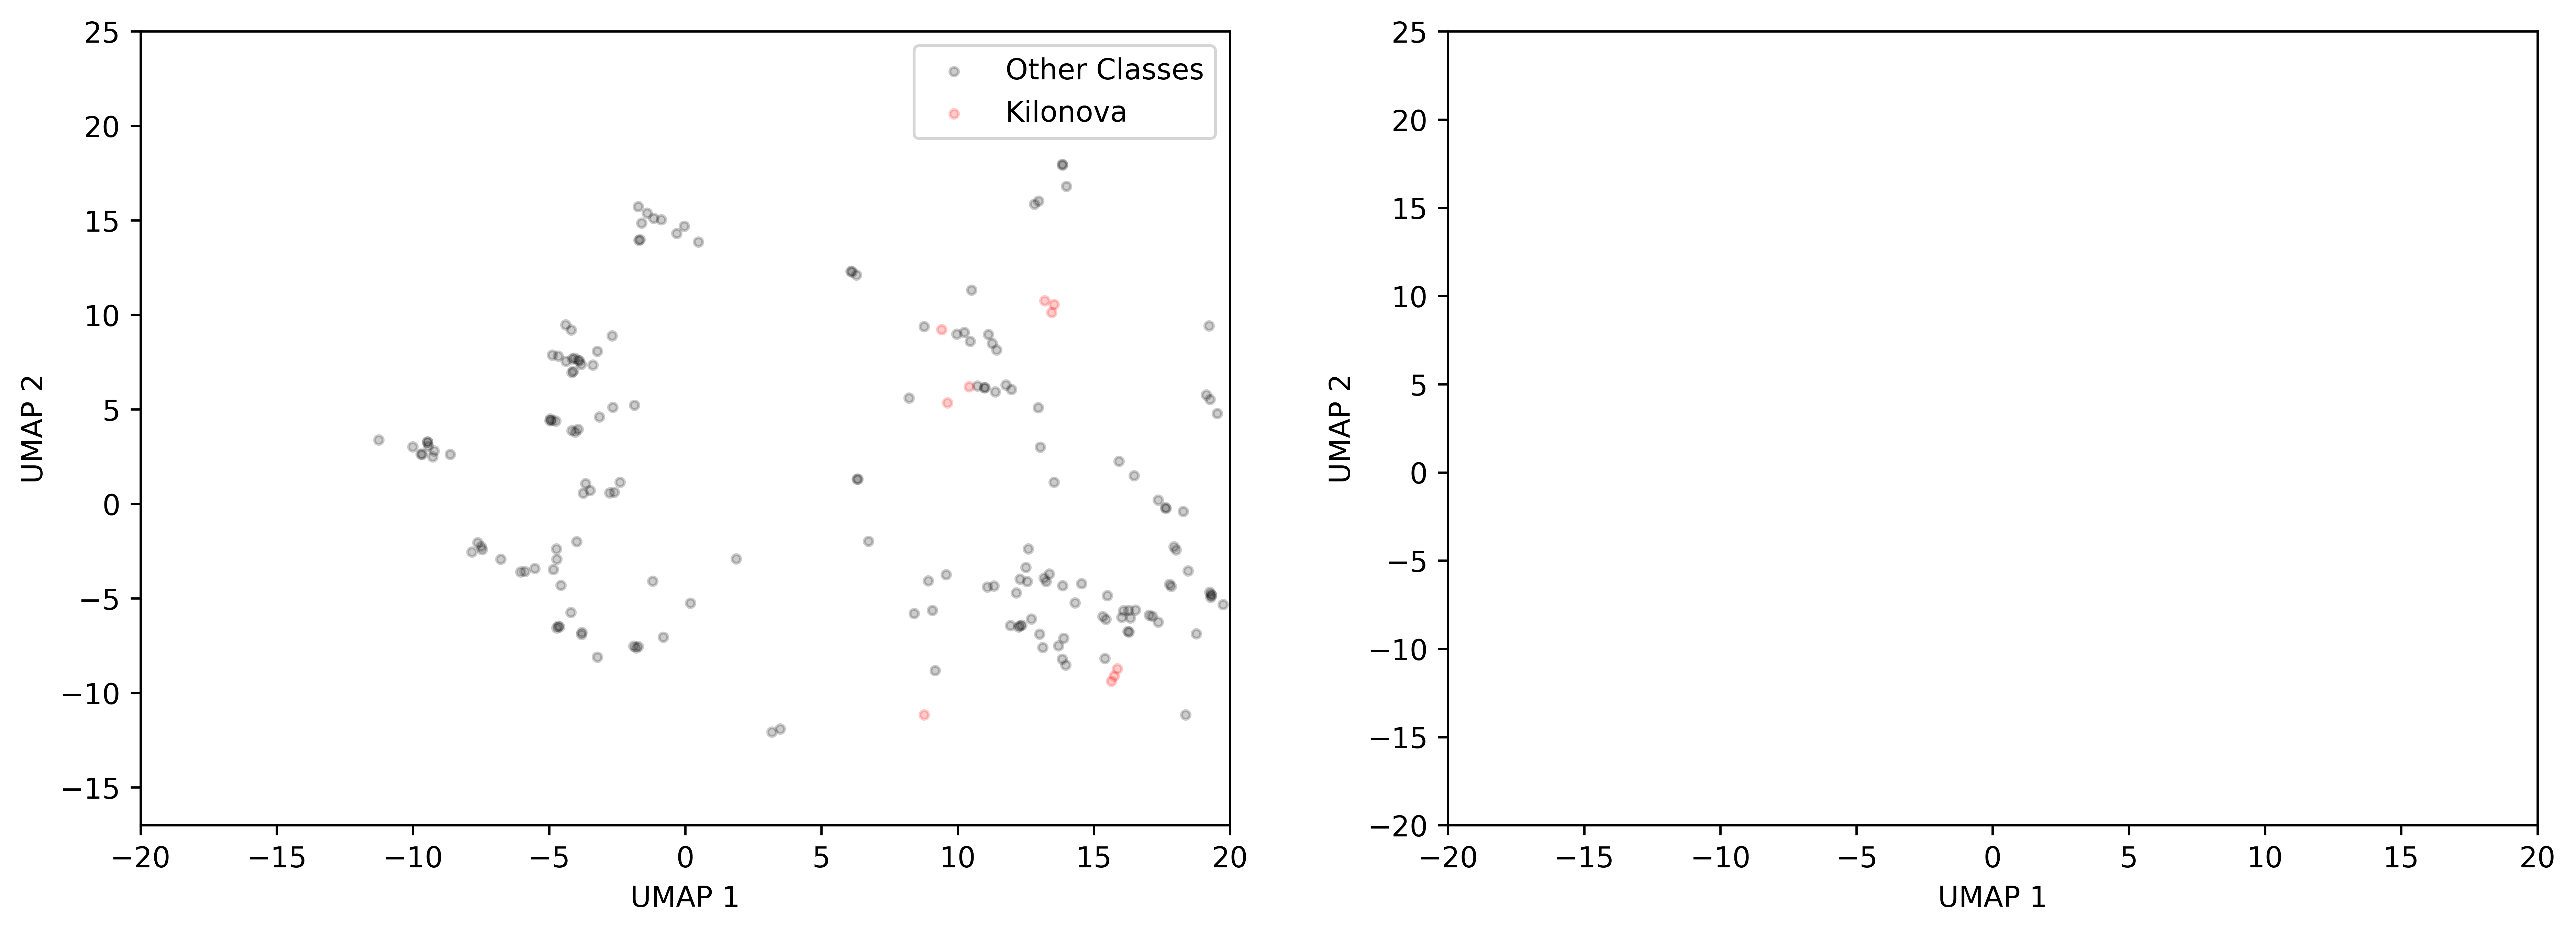

32 Days after trigger


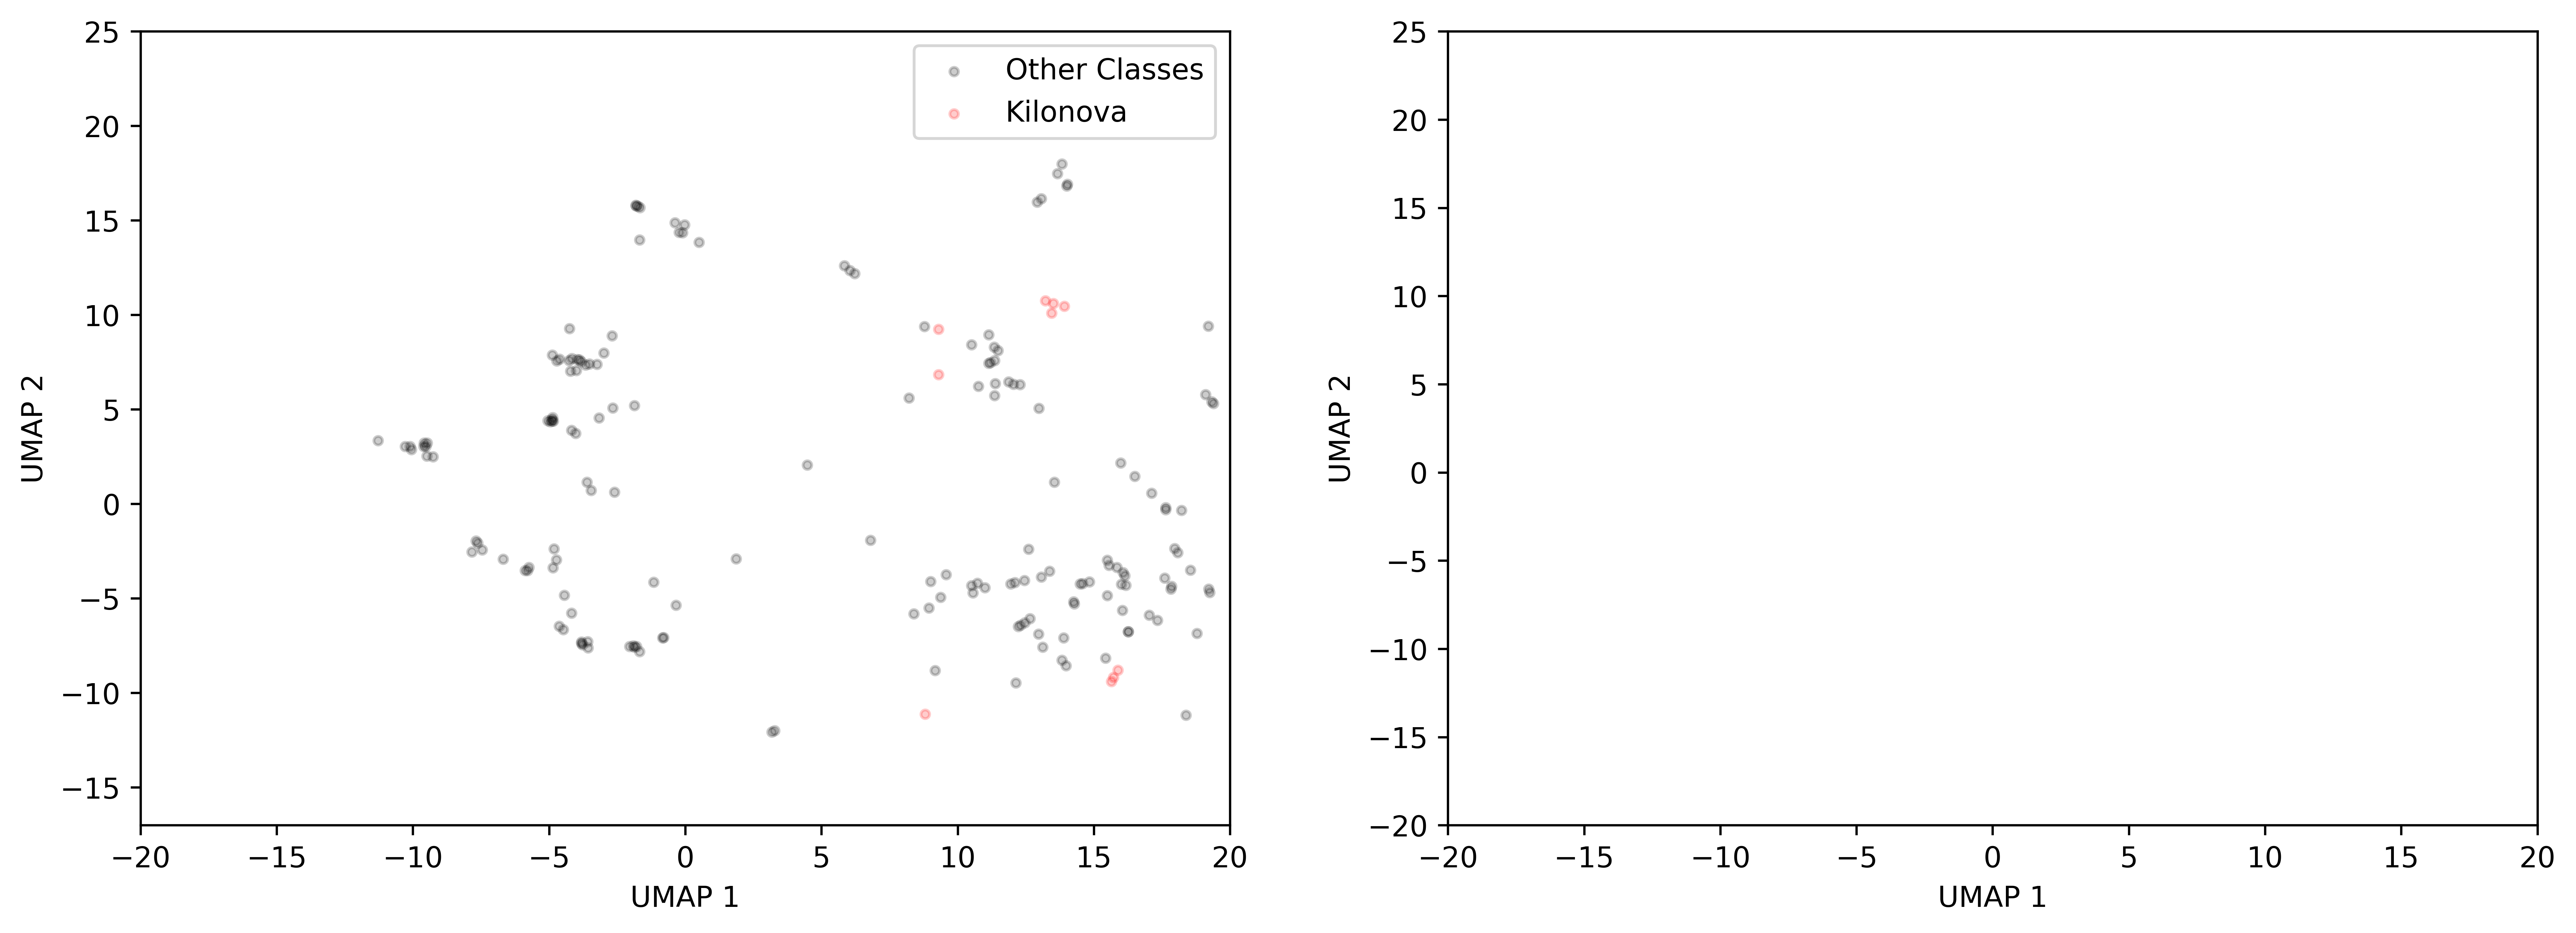

64 Days after trigger


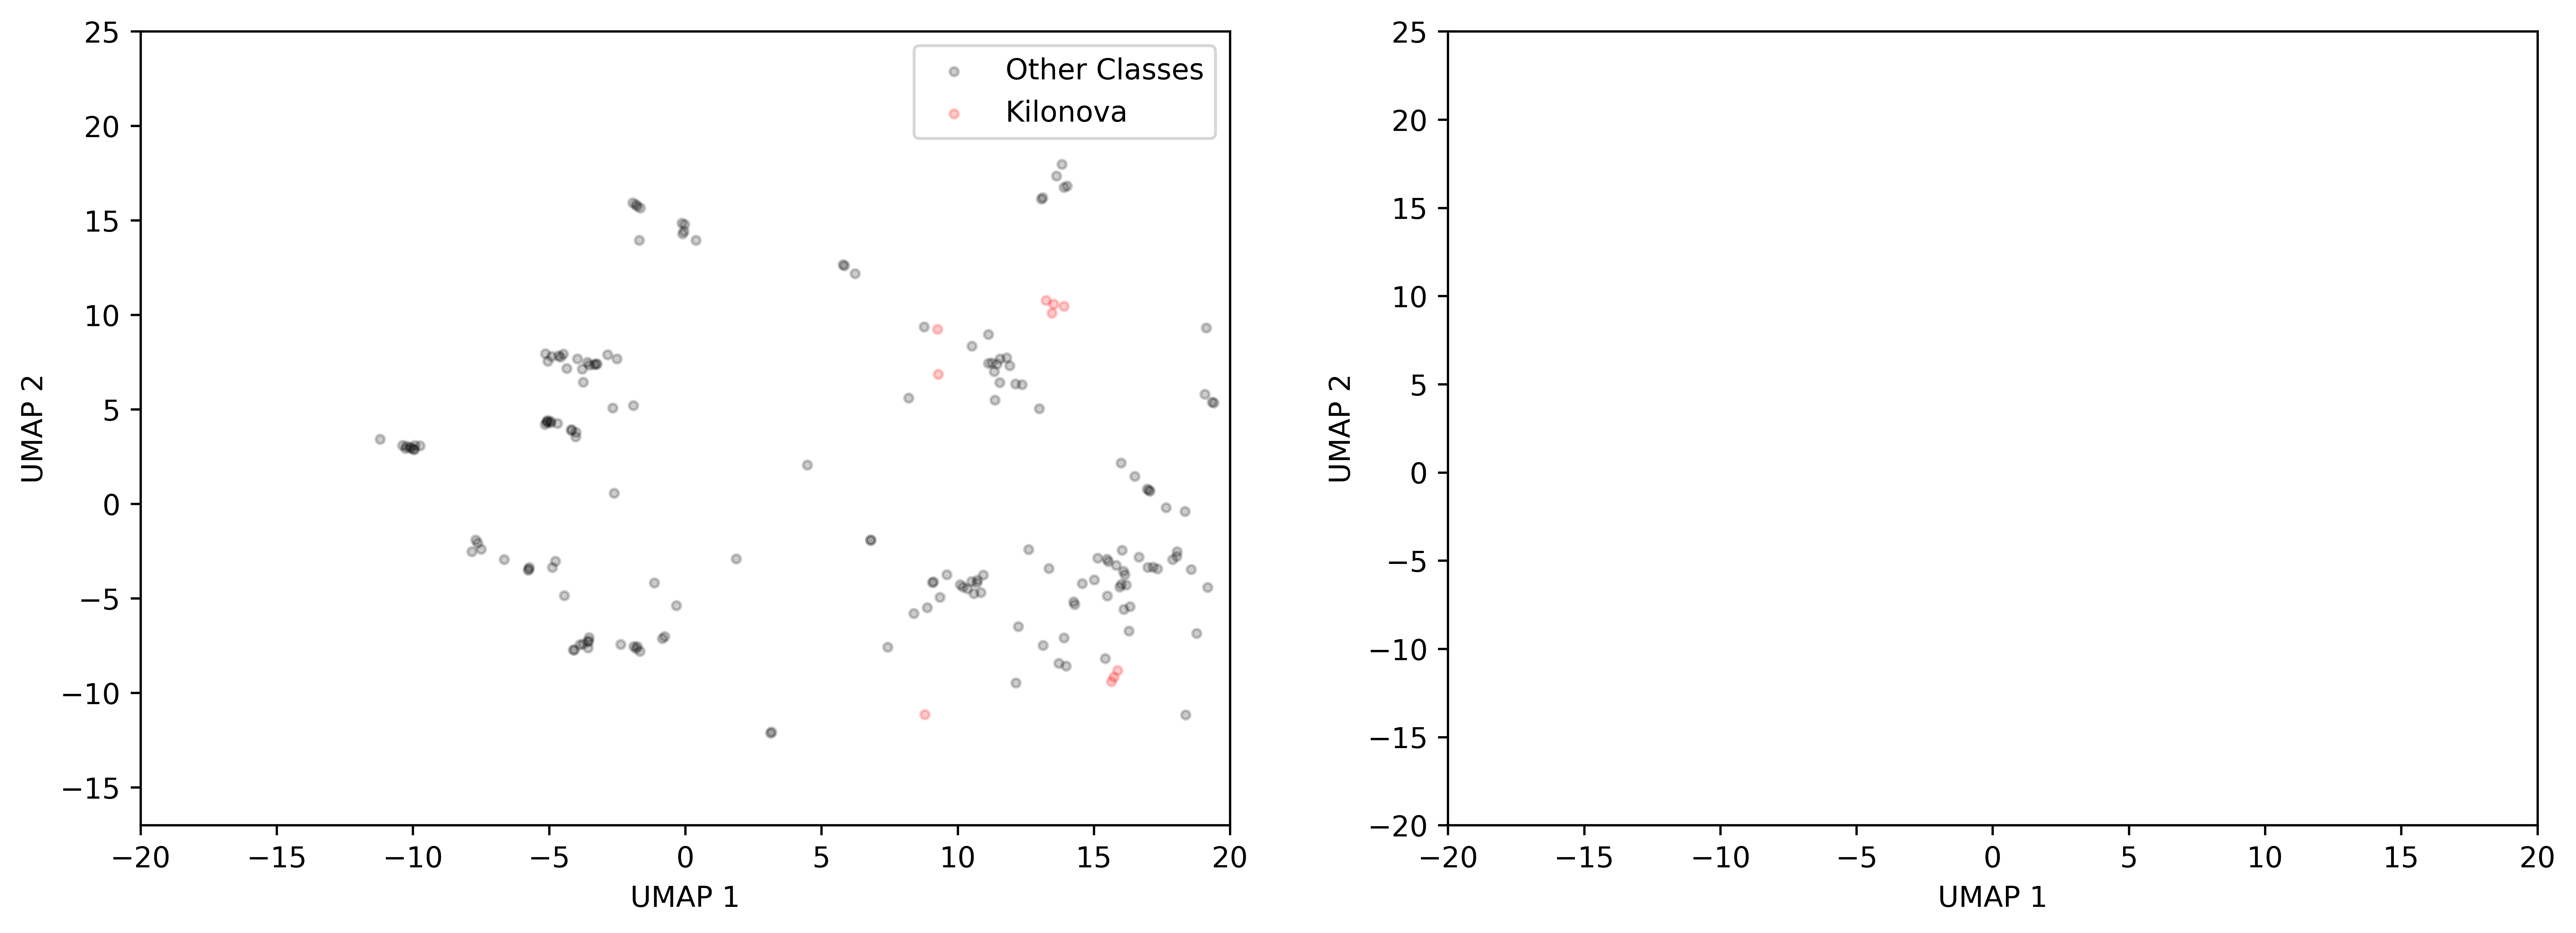

128 Days after trigger


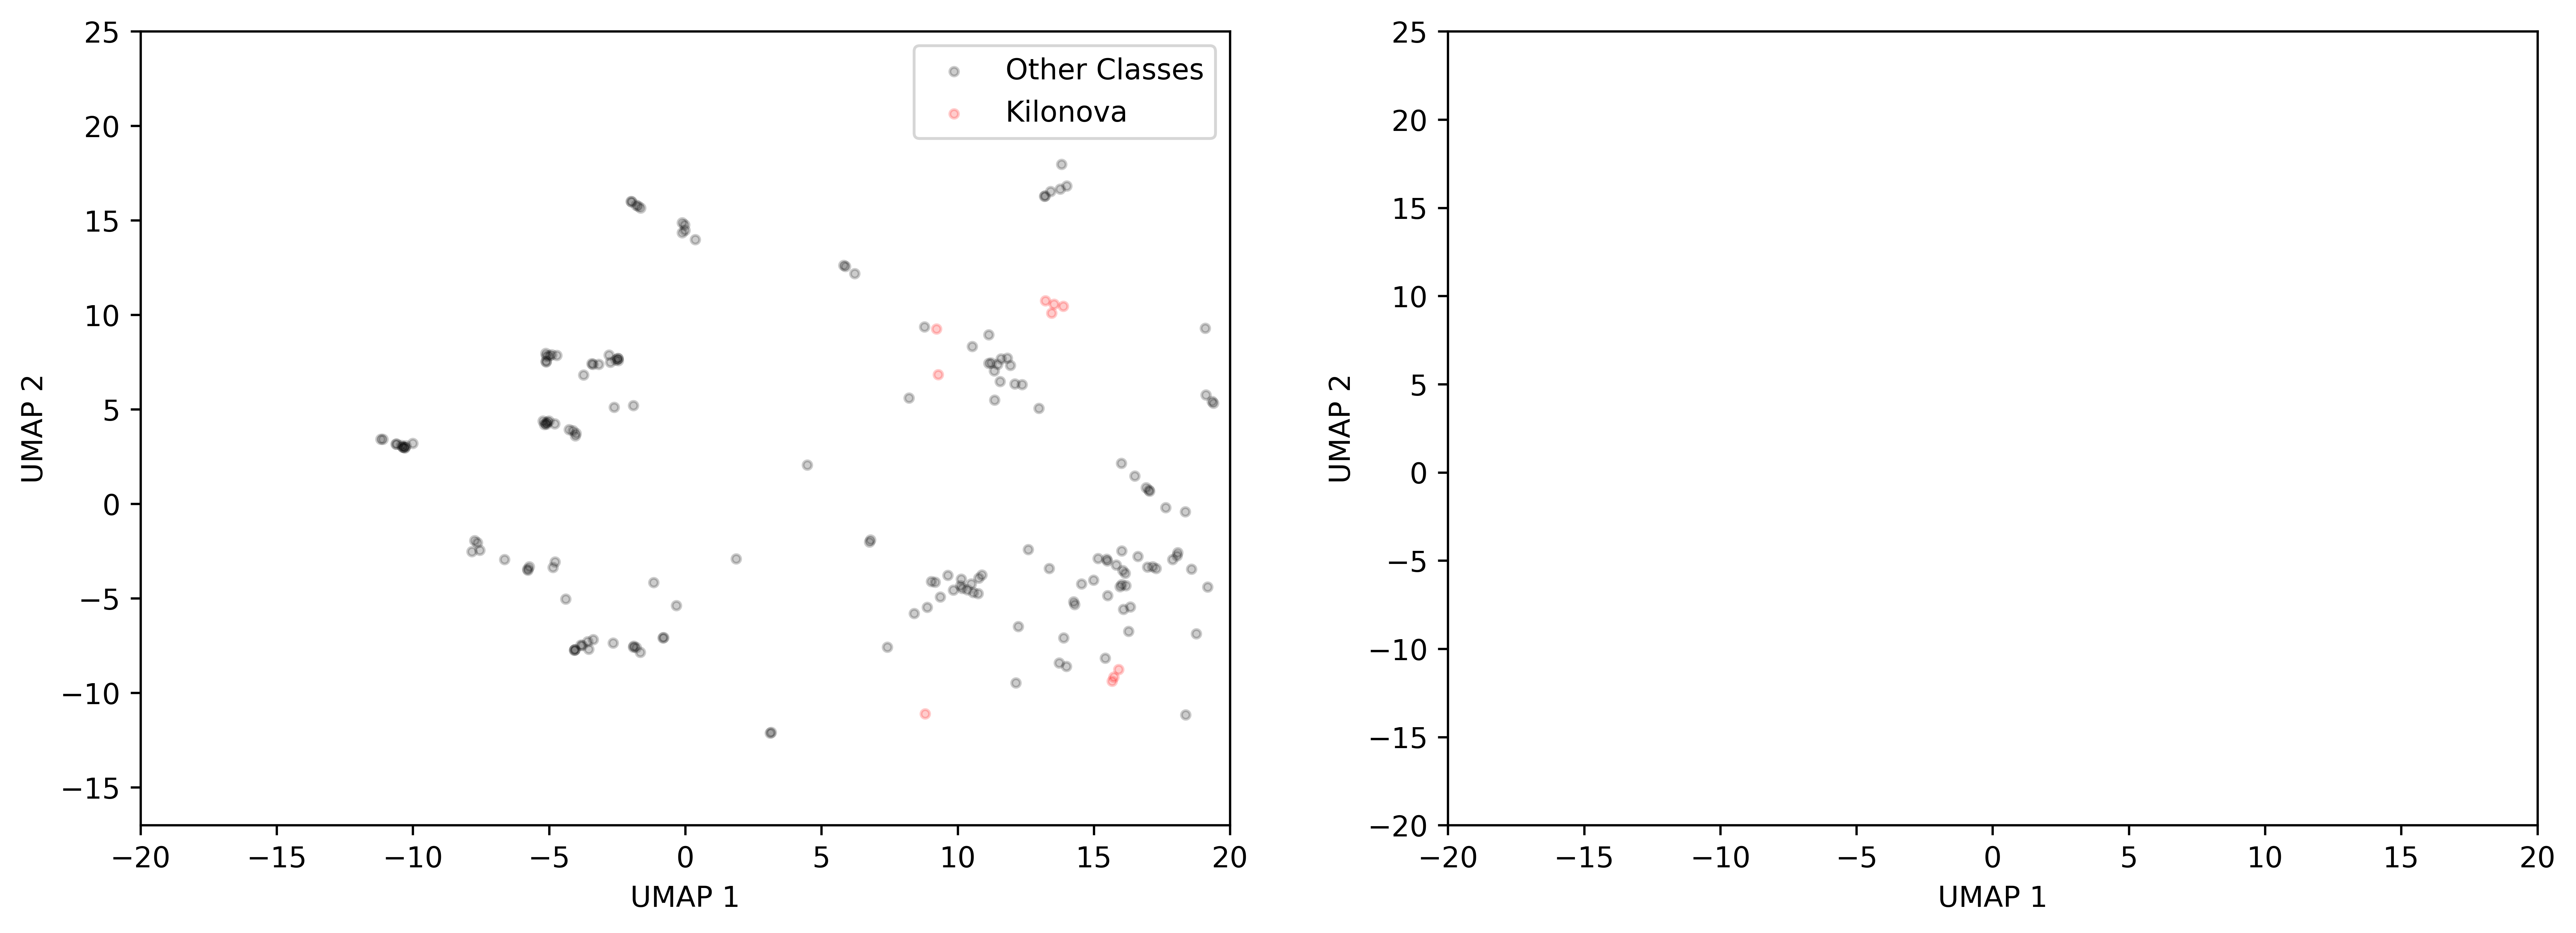

256 Days after trigger


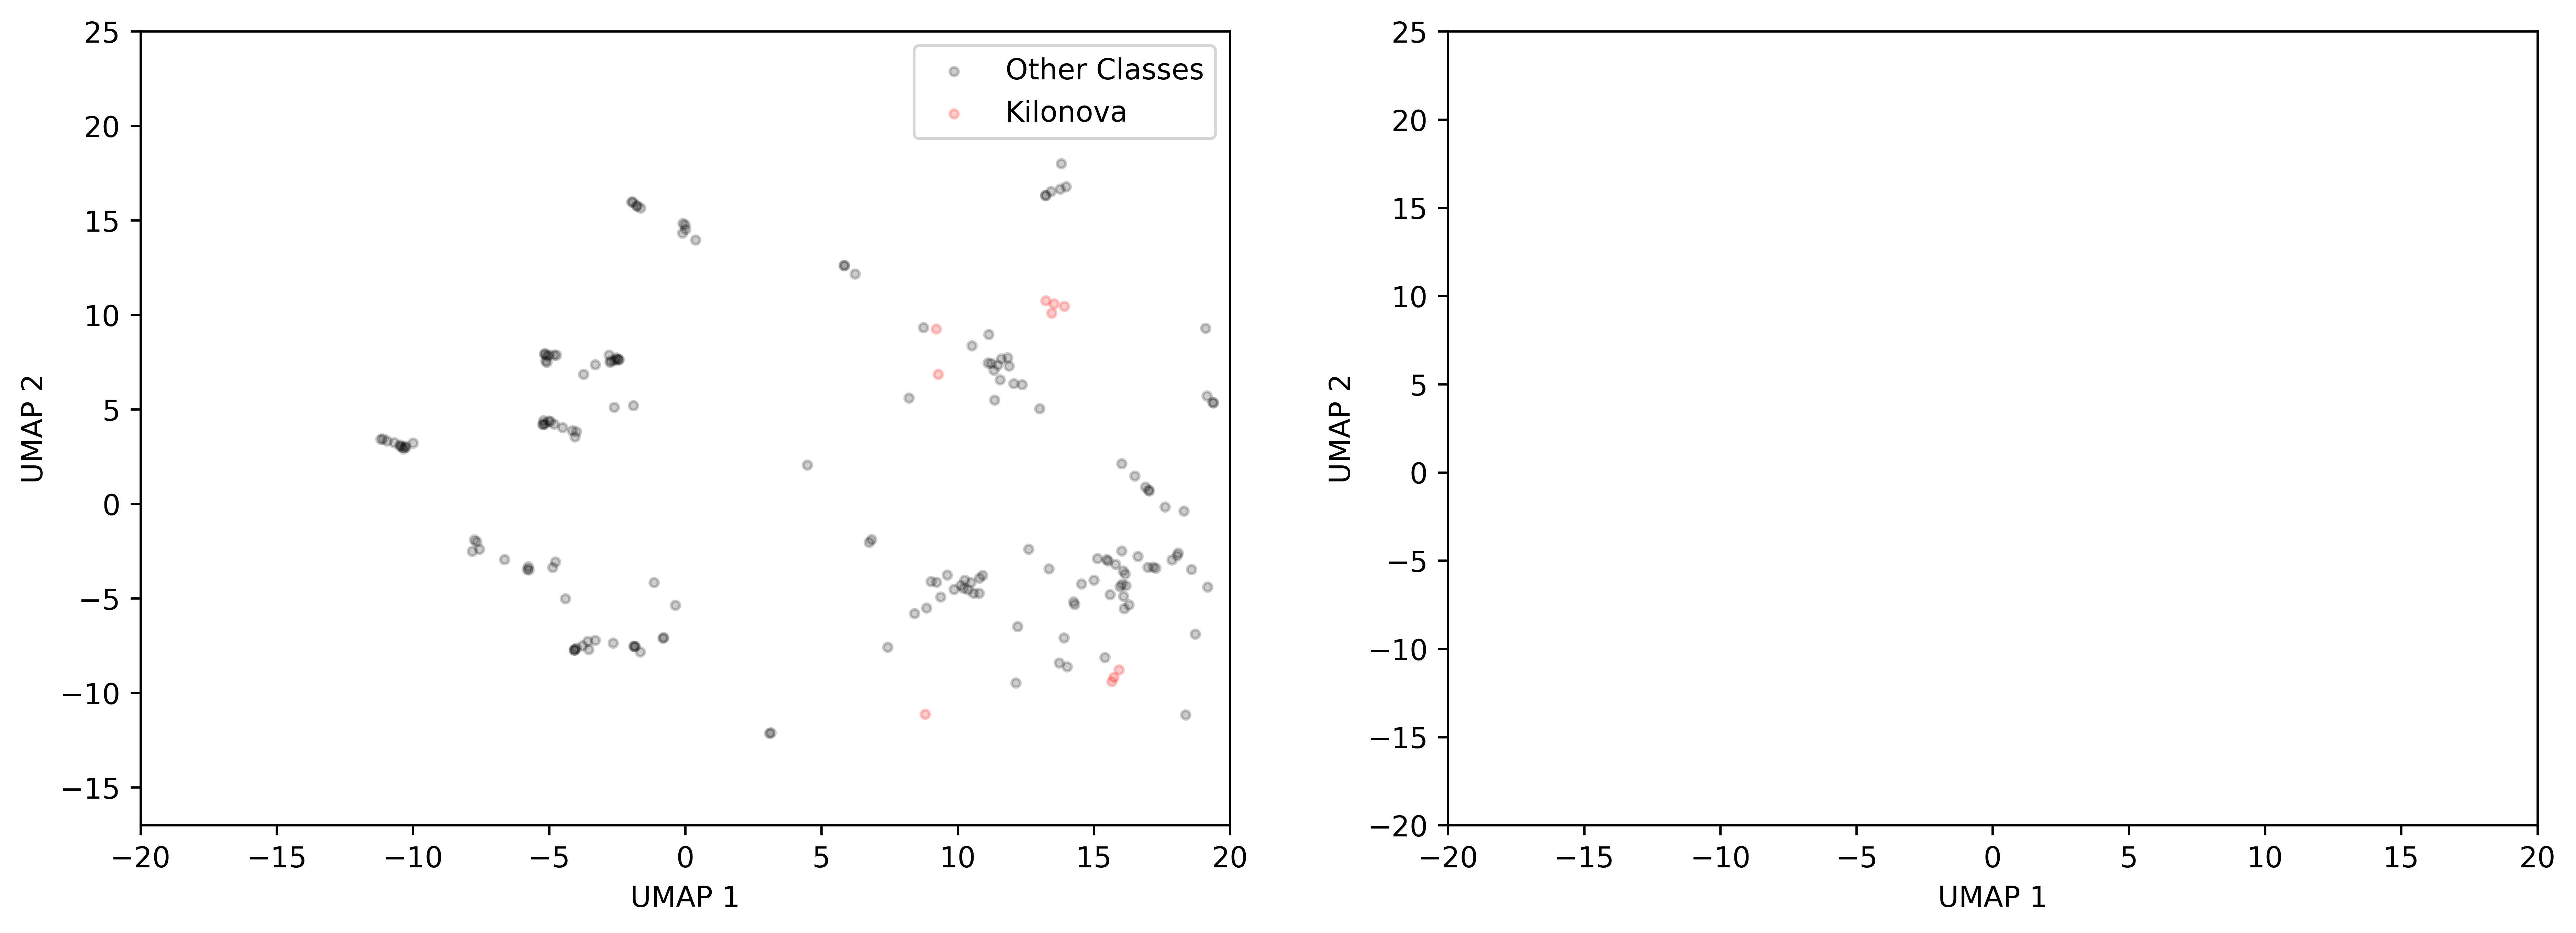

512 Days after trigger


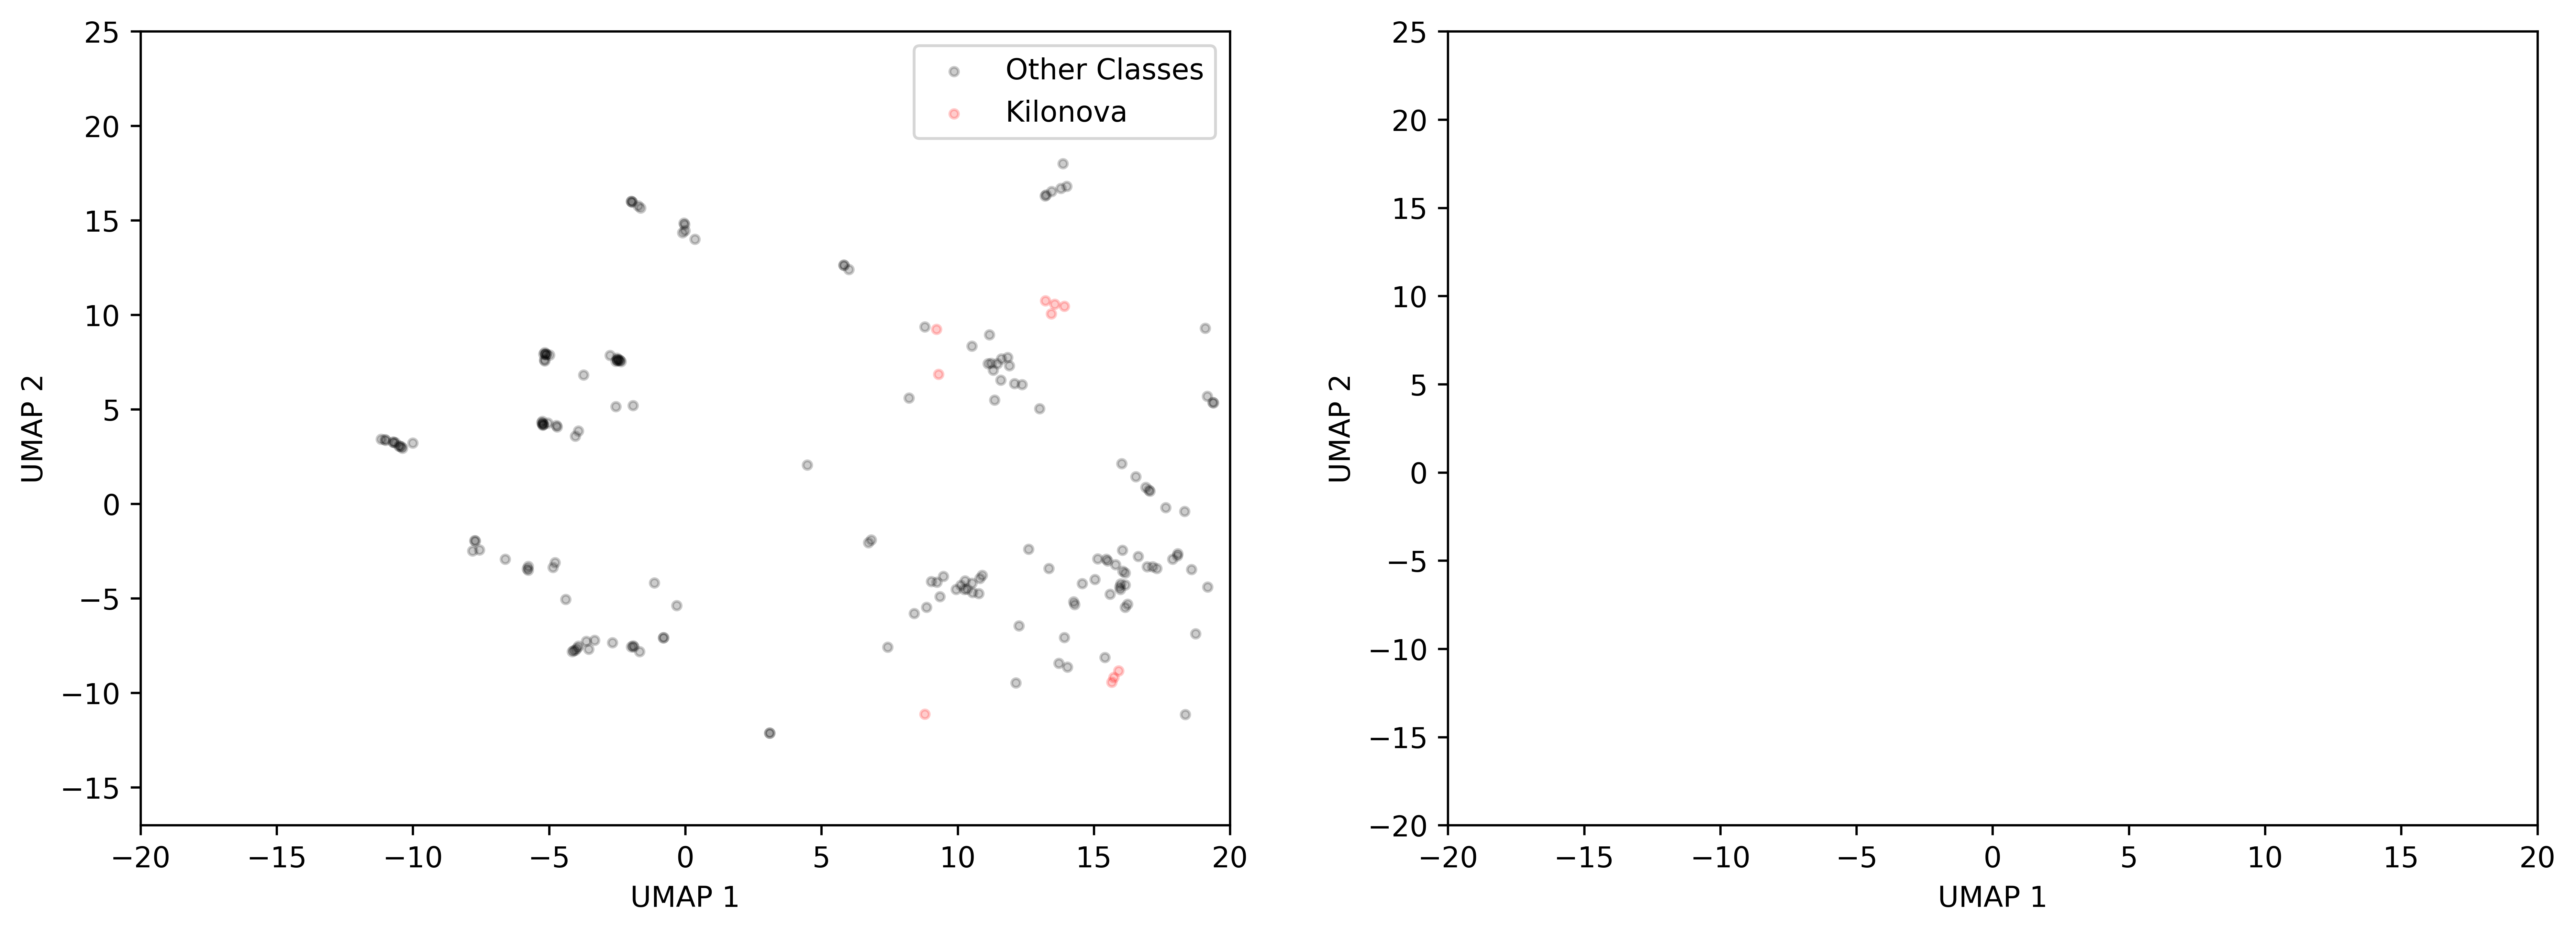

1024 Days after trigger


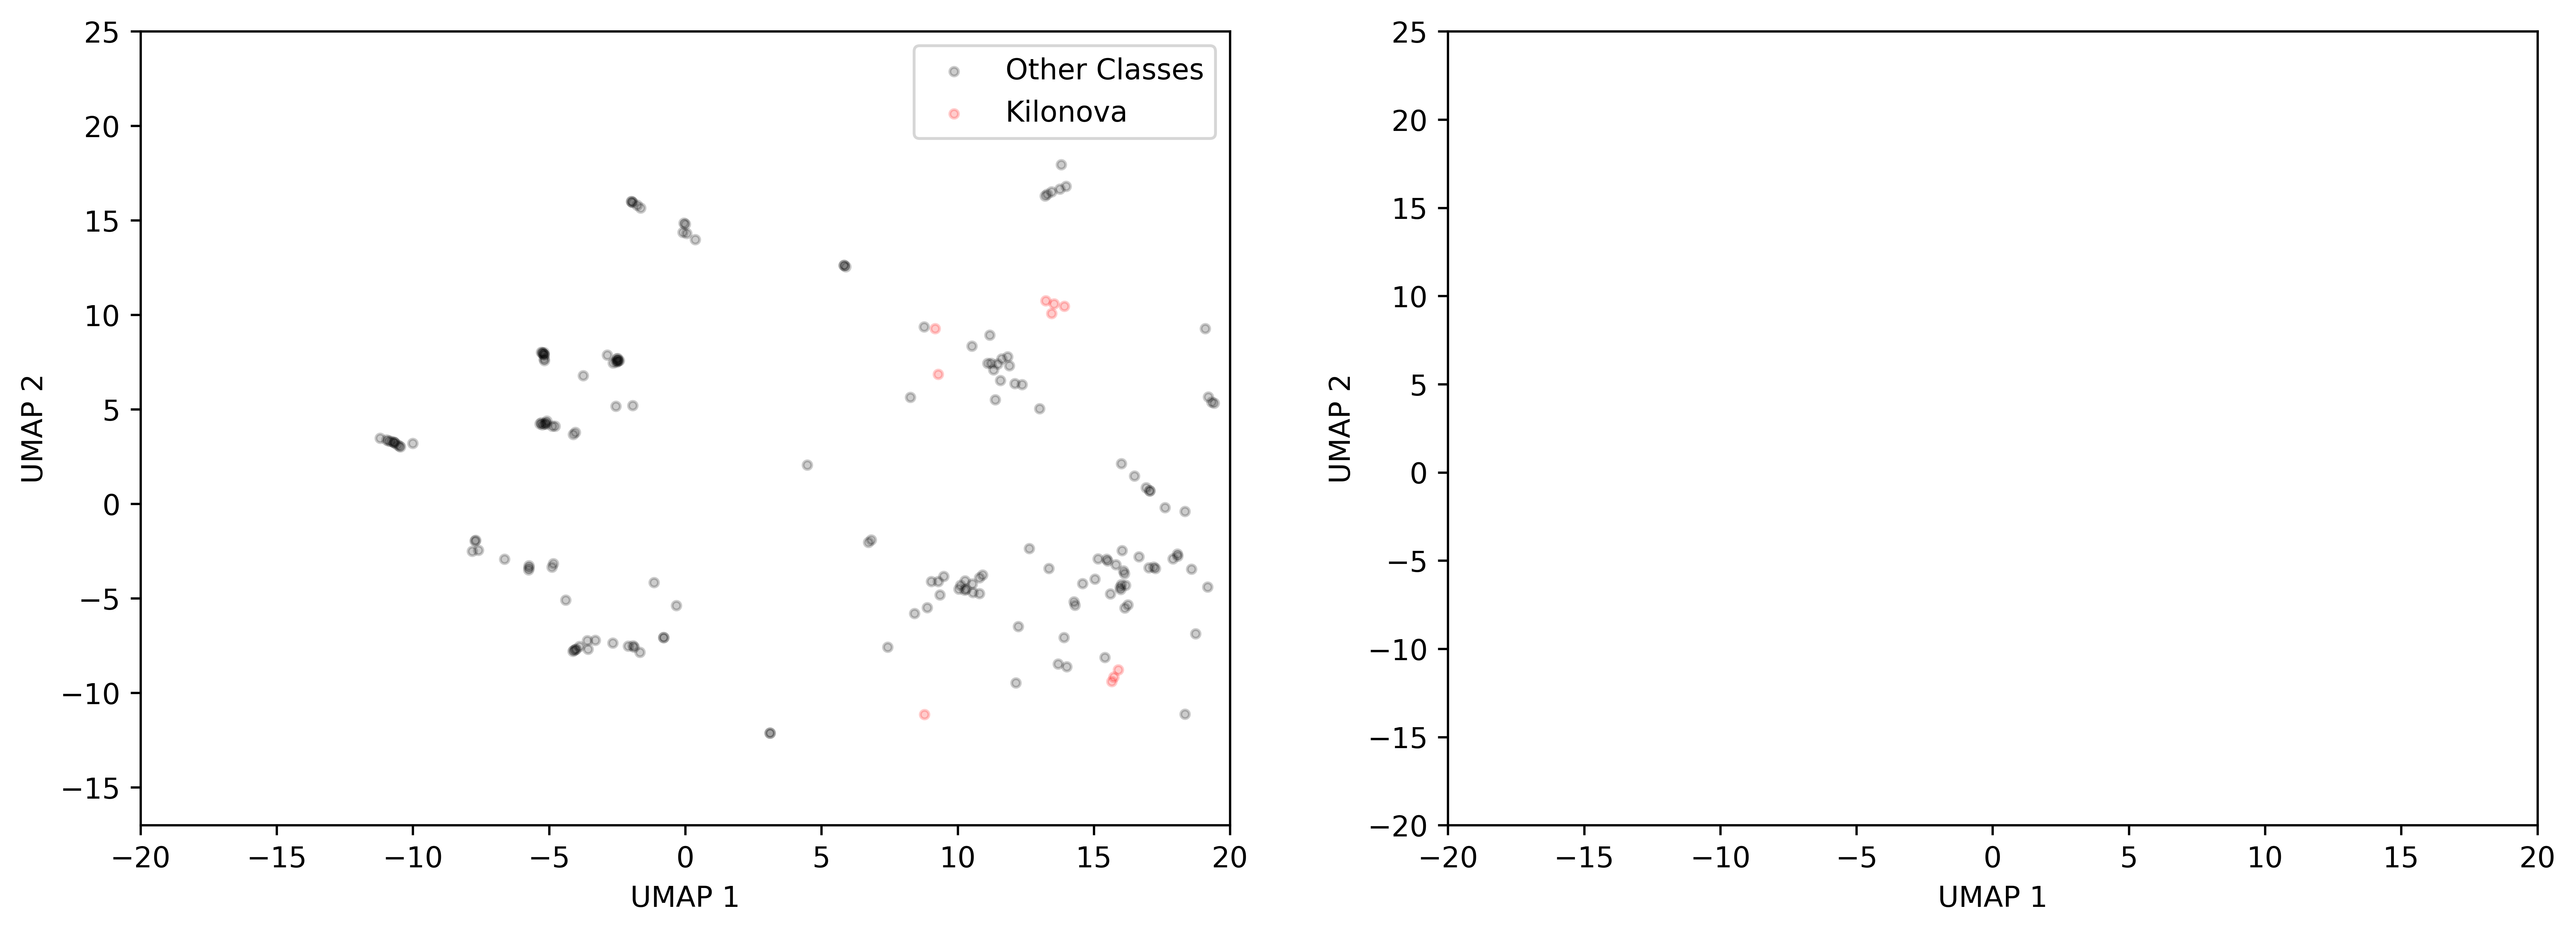

In [21]:
for i,d in enumerate(days):
    print(f"{d} Days after trigger")
    data_for_d = embedding[int(i*len(astrophysical_classes_balanced)):int((i+1)*len(astrophysical_classes_balanced)), :]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),dpi=600)

    transient_idx = np.where(np.array(astrophysical_classes_balanced)!="KN")

    axes[0].scatter(data_for_d[transient_idx, 0], data_for_d[transient_idx, 1], label="Other Classes", marker='.',alpha=0.2, color="Black")
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    #axes[0].legend()
    axes[0].set_xlim(-20, 20)
    axes[0].set_ylim(-17, 25)


    kn_idx = np.where(np.array(astrophysical_classes_balanced)=="KN")
    
    axes[0].scatter(data_for_d[kn_idx, 0], data_for_d[kn_idx, 1], label="Kilonova", marker='.', alpha=0.2, color="Red")
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")
    axes[0].legend()
    axes[1].set_xlim(-20, 20)
    axes[1].set_ylim(-20, 25)
    plt.show()
    
# SN_hierarchy_embeddings = [f"../Embedding_plots/SN_hierarchy{d}.png" for d in days]
# make_gif(SN_hierarchy_embeddings, "../Embedding_plots/SN_hierarchy.gif")
# plt.close()